### Although mAP metric is popular, I think we still need to write a new notebook to compute CV score
1. Most of the mAP calculators are integrated within particular frameworks such as detectron2, yolo, mmdet, etc... It might lack flexibility if we want to ensemble various models.
2. Some standalone codes only compute box-mAP, not segm-mAP

=> So I reimplement the code to compute mAP for this competition. **Note that it only support single class at the moment**. I use my Detectron2 model to make predictions as an example and I also compare with Detectron2 built-in CocoEvaluator

In [1]:
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import base64
from pycocotools import _mask as coco_mask
import typing as t
import zlib
import json
import torch

In [3]:
class CFG:
    
    MODEL_PATH = "/home/viktor/Documents/kaggle/hubmap-2023/experiments/smp-unet-encoder-mitb5/ckpts/segformer_epoch_40.pt"
    THRESHOLD = 0.37
    IMG_DIR = "/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train"
    N_TRAIN = 1400 # Take first N_TRAIN images for training, rest for validation
    
    min_mask_area = 0 # minimum number of pixels of mask
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json
from PIL import Image
from skimage.draw import polygon
from albumentations import Compose, Resize, HorizontalFlip, VerticalFlip, BboxParams
from torch.utils.data import Dataset, DataLoader


class HubmapDataset(Dataset):
        
    def __init__(self, image_dir, labels_file, n_train, mode='train'):
        
        assert mode in ['train', 'val'], "mode must be one of ['train', 'val']"
        self.mode = mode
        
        with open(labels_file, 'r') as json_file:
            self.json_labels = [json.loads(line) for line in json_file]

        if mode == 'train':
            self.json_labels = self.json_labels[:n_train]
        else:
            self.json_labels = self.json_labels[n_train:]

        self.image_dir = image_dir
        
        
        if mode == 'train':
            initial_augm = [
            
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                A.RandomBrightnessContrast(p=0.5, brightness_limit=0.2, contrast_limit=0.2),
                A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.1),
                A.CoarseDropout(max_holes=1, max_width=int(512 * 0.05), max_height=int(512 * 0.05), 
                                mask_fill_value=0, p=0.1),
                
                
                A.OneOf([
                        A.GaussNoise(var_limit=[10, 50]),
                        A.GaussianBlur(),
                        A.MotionBlur(),
                        ], p=0.1),
                A.MultiplicativeNoise(per_channel=True, multiplier=(0.95, 1.05)),
                
            ]
        else:
            initial_augm = []
        
        self.aug_list = initial_augm + [
                A.Resize(512, 512),
                A.Normalize(
                    mean= [0, 0, 0],
                    std= [1, 1, 1],
                    max_pixel_value = 255
                ),
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.aug_list)

    def __len__(self):
        return len(self.json_labels)
        
    def __getitem__(self, idx):
        
        image_path = os.path.join(self.image_dir, f"{self.json_labels[idx]['id']}.tif")
        image = Image.open(image_path)
        
        
        # Get the mask
        mask = np.zeros((512, 512), dtype=np.float32)
        
        for annot in self.json_labels[idx]['annotations']:
            cords = annot['coordinates']
            if annot['type'] == "blood_vessel":
                for cord in cords:
                    rr, cc = polygon(np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord]))
                    mask[rr, cc] = 1
                    
        image = np.array(image)

        # image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1)  # Shape: [C, H, W]
        # mask = torch.tensor(mask, dtype=torch.float32)


        augmented = self.augmentations(image=image, mask=mask)
        image, mask = augmented["image"], augmented["mask"]
        
        mean = torch.mean(image, dim=[1,2])
        std = torch.std(image, dim=[1,2])
        
        image = (image - mean[:, None, None]) / std[:, None, None]
        
        
        return image, mask


In [5]:
train_dataset = HubmapDataset(image_dir="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train", 
                              labels_file="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/polygons.jsonl", 
                              n_train=CFG.N_TRAIN,
                              mode='train')

val_dataset = HubmapDataset(image_dir="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train", 
                              labels_file="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/polygons.jsonl", 
                              n_train=CFG.N_TRAIN,
                              mode='val')

In [6]:
len(train_dataset), len(val_dataset)

(1400, 233)

In [7]:
# from transformers import SegformerForSemanticSegmentation
# import torch    
# import torch.nn as nn

# class Segformer(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.seg_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5",
#                                                          num_labels=1,
#                                                          ignore_mismatched_sizes=True,
#                                                          num_channels=3)
#         self.up = nn.Upsample(scale_factor=4, mode="bilinear")
        
#     def forward(self, x):
#         x = self.seg_model(x).logits
#         x = self.up(x)
#         return x



# model = Segformer()


# state_dict = torch.load(CFG.MODEL_PATH)
# model.load_state_dict(state_dict)
# model = model.to(CFG.device)


# model = model.to(CFG.device)

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.2.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.3.proj.weight', 'decode_head.line

RuntimeError: Error(s) in loading state_dict for Segformer:
	Missing key(s) in state_dict: "seg_model.segformer.encoder.patch_embeddings.0.proj.weight", "seg_model.segformer.encoder.patch_embeddings.0.proj.bias", "seg_model.segformer.encoder.patch_embeddings.0.layer_norm.weight", "seg_model.segformer.encoder.patch_embeddings.0.layer_norm.bias", "seg_model.segformer.encoder.patch_embeddings.1.proj.weight", "seg_model.segformer.encoder.patch_embeddings.1.proj.bias", "seg_model.segformer.encoder.patch_embeddings.1.layer_norm.weight", "seg_model.segformer.encoder.patch_embeddings.1.layer_norm.bias", "seg_model.segformer.encoder.patch_embeddings.2.proj.weight", "seg_model.segformer.encoder.patch_embeddings.2.proj.bias", "seg_model.segformer.encoder.patch_embeddings.2.layer_norm.weight", "seg_model.segformer.encoder.patch_embeddings.2.layer_norm.bias", "seg_model.segformer.encoder.patch_embeddings.3.proj.weight", "seg_model.segformer.encoder.patch_embeddings.3.proj.bias", "seg_model.segformer.encoder.patch_embeddings.3.layer_norm.weight", "seg_model.segformer.encoder.patch_embeddings.3.layer_norm.bias", "seg_model.segformer.encoder.block.0.0.layer_norm_1.weight", "seg_model.segformer.encoder.block.0.0.layer_norm_1.bias", "seg_model.segformer.encoder.block.0.0.attention.self.query.weight", "seg_model.segformer.encoder.block.0.0.attention.self.query.bias", "seg_model.segformer.encoder.block.0.0.attention.self.key.weight", "seg_model.segformer.encoder.block.0.0.attention.self.key.bias", "seg_model.segformer.encoder.block.0.0.attention.self.value.weight", "seg_model.segformer.encoder.block.0.0.attention.self.value.bias", "seg_model.segformer.encoder.block.0.0.attention.self.sr.weight", "seg_model.segformer.encoder.block.0.0.attention.self.sr.bias", "seg_model.segformer.encoder.block.0.0.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.0.0.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.0.0.attention.output.dense.weight", "seg_model.segformer.encoder.block.0.0.attention.output.dense.bias", "seg_model.segformer.encoder.block.0.0.layer_norm_2.weight", "seg_model.segformer.encoder.block.0.0.layer_norm_2.bias", "seg_model.segformer.encoder.block.0.0.mlp.dense1.weight", "seg_model.segformer.encoder.block.0.0.mlp.dense1.bias", "seg_model.segformer.encoder.block.0.0.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.0.0.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.0.0.mlp.dense2.weight", "seg_model.segformer.encoder.block.0.0.mlp.dense2.bias", "seg_model.segformer.encoder.block.0.1.layer_norm_1.weight", "seg_model.segformer.encoder.block.0.1.layer_norm_1.bias", "seg_model.segformer.encoder.block.0.1.attention.self.query.weight", "seg_model.segformer.encoder.block.0.1.attention.self.query.bias", "seg_model.segformer.encoder.block.0.1.attention.self.key.weight", "seg_model.segformer.encoder.block.0.1.attention.self.key.bias", "seg_model.segformer.encoder.block.0.1.attention.self.value.weight", "seg_model.segformer.encoder.block.0.1.attention.self.value.bias", "seg_model.segformer.encoder.block.0.1.attention.self.sr.weight", "seg_model.segformer.encoder.block.0.1.attention.self.sr.bias", "seg_model.segformer.encoder.block.0.1.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.0.1.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.0.1.attention.output.dense.weight", "seg_model.segformer.encoder.block.0.1.attention.output.dense.bias", "seg_model.segformer.encoder.block.0.1.layer_norm_2.weight", "seg_model.segformer.encoder.block.0.1.layer_norm_2.bias", "seg_model.segformer.encoder.block.0.1.mlp.dense1.weight", "seg_model.segformer.encoder.block.0.1.mlp.dense1.bias", "seg_model.segformer.encoder.block.0.1.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.0.1.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.0.1.mlp.dense2.weight", "seg_model.segformer.encoder.block.0.1.mlp.dense2.bias", "seg_model.segformer.encoder.block.0.2.layer_norm_1.weight", "seg_model.segformer.encoder.block.0.2.layer_norm_1.bias", "seg_model.segformer.encoder.block.0.2.attention.self.query.weight", "seg_model.segformer.encoder.block.0.2.attention.self.query.bias", "seg_model.segformer.encoder.block.0.2.attention.self.key.weight", "seg_model.segformer.encoder.block.0.2.attention.self.key.bias", "seg_model.segformer.encoder.block.0.2.attention.self.value.weight", "seg_model.segformer.encoder.block.0.2.attention.self.value.bias", "seg_model.segformer.encoder.block.0.2.attention.self.sr.weight", "seg_model.segformer.encoder.block.0.2.attention.self.sr.bias", "seg_model.segformer.encoder.block.0.2.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.0.2.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.0.2.attention.output.dense.weight", "seg_model.segformer.encoder.block.0.2.attention.output.dense.bias", "seg_model.segformer.encoder.block.0.2.layer_norm_2.weight", "seg_model.segformer.encoder.block.0.2.layer_norm_2.bias", "seg_model.segformer.encoder.block.0.2.mlp.dense1.weight", "seg_model.segformer.encoder.block.0.2.mlp.dense1.bias", "seg_model.segformer.encoder.block.0.2.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.0.2.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.0.2.mlp.dense2.weight", "seg_model.segformer.encoder.block.0.2.mlp.dense2.bias", "seg_model.segformer.encoder.block.1.0.layer_norm_1.weight", "seg_model.segformer.encoder.block.1.0.layer_norm_1.bias", "seg_model.segformer.encoder.block.1.0.attention.self.query.weight", "seg_model.segformer.encoder.block.1.0.attention.self.query.bias", "seg_model.segformer.encoder.block.1.0.attention.self.key.weight", "seg_model.segformer.encoder.block.1.0.attention.self.key.bias", "seg_model.segformer.encoder.block.1.0.attention.self.value.weight", "seg_model.segformer.encoder.block.1.0.attention.self.value.bias", "seg_model.segformer.encoder.block.1.0.attention.self.sr.weight", "seg_model.segformer.encoder.block.1.0.attention.self.sr.bias", "seg_model.segformer.encoder.block.1.0.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.1.0.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.1.0.attention.output.dense.weight", "seg_model.segformer.encoder.block.1.0.attention.output.dense.bias", "seg_model.segformer.encoder.block.1.0.layer_norm_2.weight", "seg_model.segformer.encoder.block.1.0.layer_norm_2.bias", "seg_model.segformer.encoder.block.1.0.mlp.dense1.weight", "seg_model.segformer.encoder.block.1.0.mlp.dense1.bias", "seg_model.segformer.encoder.block.1.0.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.1.0.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.1.0.mlp.dense2.weight", "seg_model.segformer.encoder.block.1.0.mlp.dense2.bias", "seg_model.segformer.encoder.block.1.1.layer_norm_1.weight", "seg_model.segformer.encoder.block.1.1.layer_norm_1.bias", "seg_model.segformer.encoder.block.1.1.attention.self.query.weight", "seg_model.segformer.encoder.block.1.1.attention.self.query.bias", "seg_model.segformer.encoder.block.1.1.attention.self.key.weight", "seg_model.segformer.encoder.block.1.1.attention.self.key.bias", "seg_model.segformer.encoder.block.1.1.attention.self.value.weight", "seg_model.segformer.encoder.block.1.1.attention.self.value.bias", "seg_model.segformer.encoder.block.1.1.attention.self.sr.weight", "seg_model.segformer.encoder.block.1.1.attention.self.sr.bias", "seg_model.segformer.encoder.block.1.1.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.1.1.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.1.1.attention.output.dense.weight", "seg_model.segformer.encoder.block.1.1.attention.output.dense.bias", "seg_model.segformer.encoder.block.1.1.layer_norm_2.weight", "seg_model.segformer.encoder.block.1.1.layer_norm_2.bias", "seg_model.segformer.encoder.block.1.1.mlp.dense1.weight", "seg_model.segformer.encoder.block.1.1.mlp.dense1.bias", "seg_model.segformer.encoder.block.1.1.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.1.1.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.1.1.mlp.dense2.weight", "seg_model.segformer.encoder.block.1.1.mlp.dense2.bias", "seg_model.segformer.encoder.block.1.2.layer_norm_1.weight", "seg_model.segformer.encoder.block.1.2.layer_norm_1.bias", "seg_model.segformer.encoder.block.1.2.attention.self.query.weight", "seg_model.segformer.encoder.block.1.2.attention.self.query.bias", "seg_model.segformer.encoder.block.1.2.attention.self.key.weight", "seg_model.segformer.encoder.block.1.2.attention.self.key.bias", "seg_model.segformer.encoder.block.1.2.attention.self.value.weight", "seg_model.segformer.encoder.block.1.2.attention.self.value.bias", "seg_model.segformer.encoder.block.1.2.attention.self.sr.weight", "seg_model.segformer.encoder.block.1.2.attention.self.sr.bias", "seg_model.segformer.encoder.block.1.2.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.1.2.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.1.2.attention.output.dense.weight", "seg_model.segformer.encoder.block.1.2.attention.output.dense.bias", "seg_model.segformer.encoder.block.1.2.layer_norm_2.weight", "seg_model.segformer.encoder.block.1.2.layer_norm_2.bias", "seg_model.segformer.encoder.block.1.2.mlp.dense1.weight", "seg_model.segformer.encoder.block.1.2.mlp.dense1.bias", "seg_model.segformer.encoder.block.1.2.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.1.2.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.1.2.mlp.dense2.weight", "seg_model.segformer.encoder.block.1.2.mlp.dense2.bias", "seg_model.segformer.encoder.block.1.3.layer_norm_1.weight", "seg_model.segformer.encoder.block.1.3.layer_norm_1.bias", "seg_model.segformer.encoder.block.1.3.attention.self.query.weight", "seg_model.segformer.encoder.block.1.3.attention.self.query.bias", "seg_model.segformer.encoder.block.1.3.attention.self.key.weight", "seg_model.segformer.encoder.block.1.3.attention.self.key.bias", "seg_model.segformer.encoder.block.1.3.attention.self.value.weight", "seg_model.segformer.encoder.block.1.3.attention.self.value.bias", "seg_model.segformer.encoder.block.1.3.attention.self.sr.weight", "seg_model.segformer.encoder.block.1.3.attention.self.sr.bias", "seg_model.segformer.encoder.block.1.3.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.1.3.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.1.3.attention.output.dense.weight", "seg_model.segformer.encoder.block.1.3.attention.output.dense.bias", "seg_model.segformer.encoder.block.1.3.layer_norm_2.weight", "seg_model.segformer.encoder.block.1.3.layer_norm_2.bias", "seg_model.segformer.encoder.block.1.3.mlp.dense1.weight", "seg_model.segformer.encoder.block.1.3.mlp.dense1.bias", "seg_model.segformer.encoder.block.1.3.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.1.3.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.1.3.mlp.dense2.weight", "seg_model.segformer.encoder.block.1.3.mlp.dense2.bias", "seg_model.segformer.encoder.block.1.4.layer_norm_1.weight", "seg_model.segformer.encoder.block.1.4.layer_norm_1.bias", "seg_model.segformer.encoder.block.1.4.attention.self.query.weight", "seg_model.segformer.encoder.block.1.4.attention.self.query.bias", "seg_model.segformer.encoder.block.1.4.attention.self.key.weight", "seg_model.segformer.encoder.block.1.4.attention.self.key.bias", "seg_model.segformer.encoder.block.1.4.attention.self.value.weight", "seg_model.segformer.encoder.block.1.4.attention.self.value.bias", "seg_model.segformer.encoder.block.1.4.attention.self.sr.weight", "seg_model.segformer.encoder.block.1.4.attention.self.sr.bias", "seg_model.segformer.encoder.block.1.4.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.1.4.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.1.4.attention.output.dense.weight", "seg_model.segformer.encoder.block.1.4.attention.output.dense.bias", "seg_model.segformer.encoder.block.1.4.layer_norm_2.weight", "seg_model.segformer.encoder.block.1.4.layer_norm_2.bias", "seg_model.segformer.encoder.block.1.4.mlp.dense1.weight", "seg_model.segformer.encoder.block.1.4.mlp.dense1.bias", "seg_model.segformer.encoder.block.1.4.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.1.4.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.1.4.mlp.dense2.weight", "seg_model.segformer.encoder.block.1.4.mlp.dense2.bias", "seg_model.segformer.encoder.block.1.5.layer_norm_1.weight", "seg_model.segformer.encoder.block.1.5.layer_norm_1.bias", "seg_model.segformer.encoder.block.1.5.attention.self.query.weight", "seg_model.segformer.encoder.block.1.5.attention.self.query.bias", "seg_model.segformer.encoder.block.1.5.attention.self.key.weight", "seg_model.segformer.encoder.block.1.5.attention.self.key.bias", "seg_model.segformer.encoder.block.1.5.attention.self.value.weight", "seg_model.segformer.encoder.block.1.5.attention.self.value.bias", "seg_model.segformer.encoder.block.1.5.attention.self.sr.weight", "seg_model.segformer.encoder.block.1.5.attention.self.sr.bias", "seg_model.segformer.encoder.block.1.5.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.1.5.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.1.5.attention.output.dense.weight", "seg_model.segformer.encoder.block.1.5.attention.output.dense.bias", "seg_model.segformer.encoder.block.1.5.layer_norm_2.weight", "seg_model.segformer.encoder.block.1.5.layer_norm_2.bias", "seg_model.segformer.encoder.block.1.5.mlp.dense1.weight", "seg_model.segformer.encoder.block.1.5.mlp.dense1.bias", "seg_model.segformer.encoder.block.1.5.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.1.5.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.1.5.mlp.dense2.weight", "seg_model.segformer.encoder.block.1.5.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.0.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.0.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.0.attention.self.query.weight", "seg_model.segformer.encoder.block.2.0.attention.self.query.bias", "seg_model.segformer.encoder.block.2.0.attention.self.key.weight", "seg_model.segformer.encoder.block.2.0.attention.self.key.bias", "seg_model.segformer.encoder.block.2.0.attention.self.value.weight", "seg_model.segformer.encoder.block.2.0.attention.self.value.bias", "seg_model.segformer.encoder.block.2.0.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.0.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.0.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.0.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.0.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.0.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.0.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.0.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.0.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.0.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.0.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.0.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.0.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.0.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.1.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.1.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.1.attention.self.query.weight", "seg_model.segformer.encoder.block.2.1.attention.self.query.bias", "seg_model.segformer.encoder.block.2.1.attention.self.key.weight", "seg_model.segformer.encoder.block.2.1.attention.self.key.bias", "seg_model.segformer.encoder.block.2.1.attention.self.value.weight", "seg_model.segformer.encoder.block.2.1.attention.self.value.bias", "seg_model.segformer.encoder.block.2.1.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.1.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.1.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.1.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.1.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.1.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.1.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.1.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.1.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.1.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.1.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.1.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.1.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.1.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.2.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.2.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.2.attention.self.query.weight", "seg_model.segformer.encoder.block.2.2.attention.self.query.bias", "seg_model.segformer.encoder.block.2.2.attention.self.key.weight", "seg_model.segformer.encoder.block.2.2.attention.self.key.bias", "seg_model.segformer.encoder.block.2.2.attention.self.value.weight", "seg_model.segformer.encoder.block.2.2.attention.self.value.bias", "seg_model.segformer.encoder.block.2.2.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.2.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.2.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.2.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.2.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.2.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.2.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.2.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.2.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.2.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.2.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.2.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.2.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.2.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.3.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.3.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.3.attention.self.query.weight", "seg_model.segformer.encoder.block.2.3.attention.self.query.bias", "seg_model.segformer.encoder.block.2.3.attention.self.key.weight", "seg_model.segformer.encoder.block.2.3.attention.self.key.bias", "seg_model.segformer.encoder.block.2.3.attention.self.value.weight", "seg_model.segformer.encoder.block.2.3.attention.self.value.bias", "seg_model.segformer.encoder.block.2.3.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.3.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.3.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.3.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.3.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.3.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.3.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.3.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.3.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.3.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.3.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.3.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.3.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.3.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.4.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.4.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.4.attention.self.query.weight", "seg_model.segformer.encoder.block.2.4.attention.self.query.bias", "seg_model.segformer.encoder.block.2.4.attention.self.key.weight", "seg_model.segformer.encoder.block.2.4.attention.self.key.bias", "seg_model.segformer.encoder.block.2.4.attention.self.value.weight", "seg_model.segformer.encoder.block.2.4.attention.self.value.bias", "seg_model.segformer.encoder.block.2.4.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.4.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.4.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.4.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.4.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.4.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.4.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.4.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.4.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.4.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.4.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.4.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.4.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.4.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.5.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.5.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.5.attention.self.query.weight", "seg_model.segformer.encoder.block.2.5.attention.self.query.bias", "seg_model.segformer.encoder.block.2.5.attention.self.key.weight", "seg_model.segformer.encoder.block.2.5.attention.self.key.bias", "seg_model.segformer.encoder.block.2.5.attention.self.value.weight", "seg_model.segformer.encoder.block.2.5.attention.self.value.bias", "seg_model.segformer.encoder.block.2.5.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.5.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.5.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.5.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.5.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.5.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.5.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.5.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.5.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.5.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.5.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.5.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.5.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.5.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.6.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.6.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.6.attention.self.query.weight", "seg_model.segformer.encoder.block.2.6.attention.self.query.bias", "seg_model.segformer.encoder.block.2.6.attention.self.key.weight", "seg_model.segformer.encoder.block.2.6.attention.self.key.bias", "seg_model.segformer.encoder.block.2.6.attention.self.value.weight", "seg_model.segformer.encoder.block.2.6.attention.self.value.bias", "seg_model.segformer.encoder.block.2.6.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.6.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.6.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.6.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.6.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.6.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.6.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.6.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.6.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.6.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.6.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.6.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.6.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.6.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.7.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.7.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.7.attention.self.query.weight", "seg_model.segformer.encoder.block.2.7.attention.self.query.bias", "seg_model.segformer.encoder.block.2.7.attention.self.key.weight", "seg_model.segformer.encoder.block.2.7.attention.self.key.bias", "seg_model.segformer.encoder.block.2.7.attention.self.value.weight", "seg_model.segformer.encoder.block.2.7.attention.self.value.bias", "seg_model.segformer.encoder.block.2.7.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.7.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.7.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.7.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.7.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.7.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.7.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.7.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.7.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.7.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.7.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.7.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.7.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.7.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.8.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.8.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.8.attention.self.query.weight", "seg_model.segformer.encoder.block.2.8.attention.self.query.bias", "seg_model.segformer.encoder.block.2.8.attention.self.key.weight", "seg_model.segformer.encoder.block.2.8.attention.self.key.bias", "seg_model.segformer.encoder.block.2.8.attention.self.value.weight", "seg_model.segformer.encoder.block.2.8.attention.self.value.bias", "seg_model.segformer.encoder.block.2.8.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.8.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.8.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.8.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.8.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.8.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.8.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.8.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.8.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.8.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.8.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.8.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.8.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.8.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.9.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.9.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.9.attention.self.query.weight", "seg_model.segformer.encoder.block.2.9.attention.self.query.bias", "seg_model.segformer.encoder.block.2.9.attention.self.key.weight", "seg_model.segformer.encoder.block.2.9.attention.self.key.bias", "seg_model.segformer.encoder.block.2.9.attention.self.value.weight", "seg_model.segformer.encoder.block.2.9.attention.self.value.bias", "seg_model.segformer.encoder.block.2.9.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.9.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.9.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.9.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.9.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.9.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.9.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.9.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.9.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.9.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.9.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.9.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.9.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.9.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.10.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.10.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.10.attention.self.query.weight", "seg_model.segformer.encoder.block.2.10.attention.self.query.bias", "seg_model.segformer.encoder.block.2.10.attention.self.key.weight", "seg_model.segformer.encoder.block.2.10.attention.self.key.bias", "seg_model.segformer.encoder.block.2.10.attention.self.value.weight", "seg_model.segformer.encoder.block.2.10.attention.self.value.bias", "seg_model.segformer.encoder.block.2.10.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.10.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.10.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.10.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.10.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.10.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.10.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.10.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.10.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.10.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.10.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.10.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.10.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.10.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.11.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.11.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.11.attention.self.query.weight", "seg_model.segformer.encoder.block.2.11.attention.self.query.bias", "seg_model.segformer.encoder.block.2.11.attention.self.key.weight", "seg_model.segformer.encoder.block.2.11.attention.self.key.bias", "seg_model.segformer.encoder.block.2.11.attention.self.value.weight", "seg_model.segformer.encoder.block.2.11.attention.self.value.bias", "seg_model.segformer.encoder.block.2.11.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.11.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.11.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.11.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.11.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.11.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.11.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.11.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.11.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.11.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.11.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.11.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.11.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.11.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.12.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.12.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.12.attention.self.query.weight", "seg_model.segformer.encoder.block.2.12.attention.self.query.bias", "seg_model.segformer.encoder.block.2.12.attention.self.key.weight", "seg_model.segformer.encoder.block.2.12.attention.self.key.bias", "seg_model.segformer.encoder.block.2.12.attention.self.value.weight", "seg_model.segformer.encoder.block.2.12.attention.self.value.bias", "seg_model.segformer.encoder.block.2.12.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.12.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.12.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.12.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.12.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.12.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.12.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.12.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.12.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.12.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.12.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.12.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.12.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.12.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.13.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.13.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.13.attention.self.query.weight", "seg_model.segformer.encoder.block.2.13.attention.self.query.bias", "seg_model.segformer.encoder.block.2.13.attention.self.key.weight", "seg_model.segformer.encoder.block.2.13.attention.self.key.bias", "seg_model.segformer.encoder.block.2.13.attention.self.value.weight", "seg_model.segformer.encoder.block.2.13.attention.self.value.bias", "seg_model.segformer.encoder.block.2.13.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.13.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.13.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.13.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.13.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.13.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.13.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.13.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.13.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.13.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.13.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.13.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.13.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.13.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.14.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.14.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.14.attention.self.query.weight", "seg_model.segformer.encoder.block.2.14.attention.self.query.bias", "seg_model.segformer.encoder.block.2.14.attention.self.key.weight", "seg_model.segformer.encoder.block.2.14.attention.self.key.bias", "seg_model.segformer.encoder.block.2.14.attention.self.value.weight", "seg_model.segformer.encoder.block.2.14.attention.self.value.bias", "seg_model.segformer.encoder.block.2.14.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.14.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.14.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.14.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.14.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.14.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.14.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.14.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.14.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.14.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.14.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.14.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.14.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.14.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.15.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.15.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.15.attention.self.query.weight", "seg_model.segformer.encoder.block.2.15.attention.self.query.bias", "seg_model.segformer.encoder.block.2.15.attention.self.key.weight", "seg_model.segformer.encoder.block.2.15.attention.self.key.bias", "seg_model.segformer.encoder.block.2.15.attention.self.value.weight", "seg_model.segformer.encoder.block.2.15.attention.self.value.bias", "seg_model.segformer.encoder.block.2.15.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.15.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.15.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.15.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.15.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.15.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.15.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.15.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.15.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.15.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.15.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.15.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.15.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.15.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.16.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.16.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.16.attention.self.query.weight", "seg_model.segformer.encoder.block.2.16.attention.self.query.bias", "seg_model.segformer.encoder.block.2.16.attention.self.key.weight", "seg_model.segformer.encoder.block.2.16.attention.self.key.bias", "seg_model.segformer.encoder.block.2.16.attention.self.value.weight", "seg_model.segformer.encoder.block.2.16.attention.self.value.bias", "seg_model.segformer.encoder.block.2.16.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.16.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.16.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.16.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.16.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.16.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.16.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.16.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.16.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.16.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.16.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.16.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.16.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.16.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.17.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.17.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.17.attention.self.query.weight", "seg_model.segformer.encoder.block.2.17.attention.self.query.bias", "seg_model.segformer.encoder.block.2.17.attention.self.key.weight", "seg_model.segformer.encoder.block.2.17.attention.self.key.bias", "seg_model.segformer.encoder.block.2.17.attention.self.value.weight", "seg_model.segformer.encoder.block.2.17.attention.self.value.bias", "seg_model.segformer.encoder.block.2.17.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.17.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.17.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.17.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.17.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.17.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.17.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.17.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.17.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.17.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.17.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.17.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.17.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.17.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.18.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.18.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.18.attention.self.query.weight", "seg_model.segformer.encoder.block.2.18.attention.self.query.bias", "seg_model.segformer.encoder.block.2.18.attention.self.key.weight", "seg_model.segformer.encoder.block.2.18.attention.self.key.bias", "seg_model.segformer.encoder.block.2.18.attention.self.value.weight", "seg_model.segformer.encoder.block.2.18.attention.self.value.bias", "seg_model.segformer.encoder.block.2.18.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.18.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.18.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.18.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.18.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.18.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.18.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.18.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.18.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.18.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.18.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.18.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.18.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.18.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.19.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.19.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.19.attention.self.query.weight", "seg_model.segformer.encoder.block.2.19.attention.self.query.bias", "seg_model.segformer.encoder.block.2.19.attention.self.key.weight", "seg_model.segformer.encoder.block.2.19.attention.self.key.bias", "seg_model.segformer.encoder.block.2.19.attention.self.value.weight", "seg_model.segformer.encoder.block.2.19.attention.self.value.bias", "seg_model.segformer.encoder.block.2.19.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.19.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.19.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.19.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.19.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.19.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.19.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.19.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.19.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.19.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.19.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.19.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.19.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.19.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.20.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.20.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.20.attention.self.query.weight", "seg_model.segformer.encoder.block.2.20.attention.self.query.bias", "seg_model.segformer.encoder.block.2.20.attention.self.key.weight", "seg_model.segformer.encoder.block.2.20.attention.self.key.bias", "seg_model.segformer.encoder.block.2.20.attention.self.value.weight", "seg_model.segformer.encoder.block.2.20.attention.self.value.bias", "seg_model.segformer.encoder.block.2.20.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.20.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.20.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.20.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.20.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.20.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.20.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.20.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.20.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.20.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.20.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.20.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.20.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.20.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.21.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.21.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.21.attention.self.query.weight", "seg_model.segformer.encoder.block.2.21.attention.self.query.bias", "seg_model.segformer.encoder.block.2.21.attention.self.key.weight", "seg_model.segformer.encoder.block.2.21.attention.self.key.bias", "seg_model.segformer.encoder.block.2.21.attention.self.value.weight", "seg_model.segformer.encoder.block.2.21.attention.self.value.bias", "seg_model.segformer.encoder.block.2.21.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.21.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.21.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.21.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.21.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.21.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.21.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.21.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.21.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.21.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.21.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.21.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.21.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.21.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.22.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.22.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.22.attention.self.query.weight", "seg_model.segformer.encoder.block.2.22.attention.self.query.bias", "seg_model.segformer.encoder.block.2.22.attention.self.key.weight", "seg_model.segformer.encoder.block.2.22.attention.self.key.bias", "seg_model.segformer.encoder.block.2.22.attention.self.value.weight", "seg_model.segformer.encoder.block.2.22.attention.self.value.bias", "seg_model.segformer.encoder.block.2.22.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.22.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.22.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.22.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.22.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.22.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.22.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.22.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.22.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.22.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.22.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.22.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.22.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.22.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.23.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.23.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.23.attention.self.query.weight", "seg_model.segformer.encoder.block.2.23.attention.self.query.bias", "seg_model.segformer.encoder.block.2.23.attention.self.key.weight", "seg_model.segformer.encoder.block.2.23.attention.self.key.bias", "seg_model.segformer.encoder.block.2.23.attention.self.value.weight", "seg_model.segformer.encoder.block.2.23.attention.self.value.bias", "seg_model.segformer.encoder.block.2.23.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.23.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.23.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.23.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.23.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.23.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.23.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.23.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.23.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.23.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.23.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.23.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.23.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.23.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.24.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.24.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.24.attention.self.query.weight", "seg_model.segformer.encoder.block.2.24.attention.self.query.bias", "seg_model.segformer.encoder.block.2.24.attention.self.key.weight", "seg_model.segformer.encoder.block.2.24.attention.self.key.bias", "seg_model.segformer.encoder.block.2.24.attention.self.value.weight", "seg_model.segformer.encoder.block.2.24.attention.self.value.bias", "seg_model.segformer.encoder.block.2.24.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.24.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.24.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.24.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.24.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.24.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.24.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.24.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.24.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.24.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.24.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.24.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.24.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.24.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.25.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.25.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.25.attention.self.query.weight", "seg_model.segformer.encoder.block.2.25.attention.self.query.bias", "seg_model.segformer.encoder.block.2.25.attention.self.key.weight", "seg_model.segformer.encoder.block.2.25.attention.self.key.bias", "seg_model.segformer.encoder.block.2.25.attention.self.value.weight", "seg_model.segformer.encoder.block.2.25.attention.self.value.bias", "seg_model.segformer.encoder.block.2.25.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.25.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.25.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.25.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.25.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.25.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.25.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.25.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.25.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.25.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.25.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.25.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.25.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.25.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.26.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.26.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.26.attention.self.query.weight", "seg_model.segformer.encoder.block.2.26.attention.self.query.bias", "seg_model.segformer.encoder.block.2.26.attention.self.key.weight", "seg_model.segformer.encoder.block.2.26.attention.self.key.bias", "seg_model.segformer.encoder.block.2.26.attention.self.value.weight", "seg_model.segformer.encoder.block.2.26.attention.self.value.bias", "seg_model.segformer.encoder.block.2.26.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.26.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.26.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.26.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.26.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.26.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.26.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.26.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.26.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.26.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.26.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.26.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.26.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.26.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.27.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.27.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.27.attention.self.query.weight", "seg_model.segformer.encoder.block.2.27.attention.self.query.bias", "seg_model.segformer.encoder.block.2.27.attention.self.key.weight", "seg_model.segformer.encoder.block.2.27.attention.self.key.bias", "seg_model.segformer.encoder.block.2.27.attention.self.value.weight", "seg_model.segformer.encoder.block.2.27.attention.self.value.bias", "seg_model.segformer.encoder.block.2.27.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.27.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.27.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.27.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.27.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.27.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.27.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.27.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.27.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.27.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.27.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.27.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.27.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.27.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.28.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.28.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.28.attention.self.query.weight", "seg_model.segformer.encoder.block.2.28.attention.self.query.bias", "seg_model.segformer.encoder.block.2.28.attention.self.key.weight", "seg_model.segformer.encoder.block.2.28.attention.self.key.bias", "seg_model.segformer.encoder.block.2.28.attention.self.value.weight", "seg_model.segformer.encoder.block.2.28.attention.self.value.bias", "seg_model.segformer.encoder.block.2.28.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.28.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.28.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.28.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.28.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.28.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.28.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.28.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.28.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.28.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.28.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.28.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.28.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.28.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.29.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.29.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.29.attention.self.query.weight", "seg_model.segformer.encoder.block.2.29.attention.self.query.bias", "seg_model.segformer.encoder.block.2.29.attention.self.key.weight", "seg_model.segformer.encoder.block.2.29.attention.self.key.bias", "seg_model.segformer.encoder.block.2.29.attention.self.value.weight", "seg_model.segformer.encoder.block.2.29.attention.self.value.bias", "seg_model.segformer.encoder.block.2.29.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.29.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.29.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.29.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.29.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.29.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.29.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.29.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.29.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.29.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.29.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.29.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.29.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.29.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.30.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.30.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.30.attention.self.query.weight", "seg_model.segformer.encoder.block.2.30.attention.self.query.bias", "seg_model.segformer.encoder.block.2.30.attention.self.key.weight", "seg_model.segformer.encoder.block.2.30.attention.self.key.bias", "seg_model.segformer.encoder.block.2.30.attention.self.value.weight", "seg_model.segformer.encoder.block.2.30.attention.self.value.bias", "seg_model.segformer.encoder.block.2.30.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.30.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.30.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.30.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.30.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.30.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.30.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.30.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.30.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.30.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.30.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.30.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.30.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.30.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.31.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.31.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.31.attention.self.query.weight", "seg_model.segformer.encoder.block.2.31.attention.self.query.bias", "seg_model.segformer.encoder.block.2.31.attention.self.key.weight", "seg_model.segformer.encoder.block.2.31.attention.self.key.bias", "seg_model.segformer.encoder.block.2.31.attention.self.value.weight", "seg_model.segformer.encoder.block.2.31.attention.self.value.bias", "seg_model.segformer.encoder.block.2.31.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.31.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.31.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.31.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.31.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.31.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.31.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.31.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.31.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.31.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.31.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.31.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.31.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.31.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.32.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.32.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.32.attention.self.query.weight", "seg_model.segformer.encoder.block.2.32.attention.self.query.bias", "seg_model.segformer.encoder.block.2.32.attention.self.key.weight", "seg_model.segformer.encoder.block.2.32.attention.self.key.bias", "seg_model.segformer.encoder.block.2.32.attention.self.value.weight", "seg_model.segformer.encoder.block.2.32.attention.self.value.bias", "seg_model.segformer.encoder.block.2.32.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.32.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.32.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.32.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.32.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.32.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.32.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.32.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.32.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.32.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.32.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.32.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.32.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.32.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.33.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.33.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.33.attention.self.query.weight", "seg_model.segformer.encoder.block.2.33.attention.self.query.bias", "seg_model.segformer.encoder.block.2.33.attention.self.key.weight", "seg_model.segformer.encoder.block.2.33.attention.self.key.bias", "seg_model.segformer.encoder.block.2.33.attention.self.value.weight", "seg_model.segformer.encoder.block.2.33.attention.self.value.bias", "seg_model.segformer.encoder.block.2.33.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.33.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.33.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.33.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.33.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.33.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.33.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.33.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.33.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.33.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.33.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.33.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.33.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.33.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.34.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.34.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.34.attention.self.query.weight", "seg_model.segformer.encoder.block.2.34.attention.self.query.bias", "seg_model.segformer.encoder.block.2.34.attention.self.key.weight", "seg_model.segformer.encoder.block.2.34.attention.self.key.bias", "seg_model.segformer.encoder.block.2.34.attention.self.value.weight", "seg_model.segformer.encoder.block.2.34.attention.self.value.bias", "seg_model.segformer.encoder.block.2.34.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.34.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.34.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.34.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.34.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.34.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.34.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.34.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.34.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.34.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.34.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.34.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.34.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.34.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.35.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.35.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.35.attention.self.query.weight", "seg_model.segformer.encoder.block.2.35.attention.self.query.bias", "seg_model.segformer.encoder.block.2.35.attention.self.key.weight", "seg_model.segformer.encoder.block.2.35.attention.self.key.bias", "seg_model.segformer.encoder.block.2.35.attention.self.value.weight", "seg_model.segformer.encoder.block.2.35.attention.self.value.bias", "seg_model.segformer.encoder.block.2.35.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.35.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.35.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.35.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.35.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.35.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.35.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.35.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.35.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.35.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.35.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.35.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.35.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.35.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.36.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.36.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.36.attention.self.query.weight", "seg_model.segformer.encoder.block.2.36.attention.self.query.bias", "seg_model.segformer.encoder.block.2.36.attention.self.key.weight", "seg_model.segformer.encoder.block.2.36.attention.self.key.bias", "seg_model.segformer.encoder.block.2.36.attention.self.value.weight", "seg_model.segformer.encoder.block.2.36.attention.self.value.bias", "seg_model.segformer.encoder.block.2.36.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.36.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.36.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.36.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.36.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.36.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.36.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.36.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.36.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.36.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.36.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.36.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.36.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.36.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.37.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.37.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.37.attention.self.query.weight", "seg_model.segformer.encoder.block.2.37.attention.self.query.bias", "seg_model.segformer.encoder.block.2.37.attention.self.key.weight", "seg_model.segformer.encoder.block.2.37.attention.self.key.bias", "seg_model.segformer.encoder.block.2.37.attention.self.value.weight", "seg_model.segformer.encoder.block.2.37.attention.self.value.bias", "seg_model.segformer.encoder.block.2.37.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.37.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.37.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.37.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.37.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.37.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.37.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.37.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.37.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.37.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.37.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.37.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.37.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.37.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.38.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.38.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.38.attention.self.query.weight", "seg_model.segformer.encoder.block.2.38.attention.self.query.bias", "seg_model.segformer.encoder.block.2.38.attention.self.key.weight", "seg_model.segformer.encoder.block.2.38.attention.self.key.bias", "seg_model.segformer.encoder.block.2.38.attention.self.value.weight", "seg_model.segformer.encoder.block.2.38.attention.self.value.bias", "seg_model.segformer.encoder.block.2.38.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.38.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.38.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.38.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.38.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.38.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.38.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.38.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.38.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.38.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.38.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.38.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.38.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.38.mlp.dense2.bias", "seg_model.segformer.encoder.block.2.39.layer_norm_1.weight", "seg_model.segformer.encoder.block.2.39.layer_norm_1.bias", "seg_model.segformer.encoder.block.2.39.attention.self.query.weight", "seg_model.segformer.encoder.block.2.39.attention.self.query.bias", "seg_model.segformer.encoder.block.2.39.attention.self.key.weight", "seg_model.segformer.encoder.block.2.39.attention.self.key.bias", "seg_model.segformer.encoder.block.2.39.attention.self.value.weight", "seg_model.segformer.encoder.block.2.39.attention.self.value.bias", "seg_model.segformer.encoder.block.2.39.attention.self.sr.weight", "seg_model.segformer.encoder.block.2.39.attention.self.sr.bias", "seg_model.segformer.encoder.block.2.39.attention.self.layer_norm.weight", "seg_model.segformer.encoder.block.2.39.attention.self.layer_norm.bias", "seg_model.segformer.encoder.block.2.39.attention.output.dense.weight", "seg_model.segformer.encoder.block.2.39.attention.output.dense.bias", "seg_model.segformer.encoder.block.2.39.layer_norm_2.weight", "seg_model.segformer.encoder.block.2.39.layer_norm_2.bias", "seg_model.segformer.encoder.block.2.39.mlp.dense1.weight", "seg_model.segformer.encoder.block.2.39.mlp.dense1.bias", "seg_model.segformer.encoder.block.2.39.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.2.39.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.2.39.mlp.dense2.weight", "seg_model.segformer.encoder.block.2.39.mlp.dense2.bias", "seg_model.segformer.encoder.block.3.0.layer_norm_1.weight", "seg_model.segformer.encoder.block.3.0.layer_norm_1.bias", "seg_model.segformer.encoder.block.3.0.attention.self.query.weight", "seg_model.segformer.encoder.block.3.0.attention.self.query.bias", "seg_model.segformer.encoder.block.3.0.attention.self.key.weight", "seg_model.segformer.encoder.block.3.0.attention.self.key.bias", "seg_model.segformer.encoder.block.3.0.attention.self.value.weight", "seg_model.segformer.encoder.block.3.0.attention.self.value.bias", "seg_model.segformer.encoder.block.3.0.attention.output.dense.weight", "seg_model.segformer.encoder.block.3.0.attention.output.dense.bias", "seg_model.segformer.encoder.block.3.0.layer_norm_2.weight", "seg_model.segformer.encoder.block.3.0.layer_norm_2.bias", "seg_model.segformer.encoder.block.3.0.mlp.dense1.weight", "seg_model.segformer.encoder.block.3.0.mlp.dense1.bias", "seg_model.segformer.encoder.block.3.0.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.3.0.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.3.0.mlp.dense2.weight", "seg_model.segformer.encoder.block.3.0.mlp.dense2.bias", "seg_model.segformer.encoder.block.3.1.layer_norm_1.weight", "seg_model.segformer.encoder.block.3.1.layer_norm_1.bias", "seg_model.segformer.encoder.block.3.1.attention.self.query.weight", "seg_model.segformer.encoder.block.3.1.attention.self.query.bias", "seg_model.segformer.encoder.block.3.1.attention.self.key.weight", "seg_model.segformer.encoder.block.3.1.attention.self.key.bias", "seg_model.segformer.encoder.block.3.1.attention.self.value.weight", "seg_model.segformer.encoder.block.3.1.attention.self.value.bias", "seg_model.segformer.encoder.block.3.1.attention.output.dense.weight", "seg_model.segformer.encoder.block.3.1.attention.output.dense.bias", "seg_model.segformer.encoder.block.3.1.layer_norm_2.weight", "seg_model.segformer.encoder.block.3.1.layer_norm_2.bias", "seg_model.segformer.encoder.block.3.1.mlp.dense1.weight", "seg_model.segformer.encoder.block.3.1.mlp.dense1.bias", "seg_model.segformer.encoder.block.3.1.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.3.1.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.3.1.mlp.dense2.weight", "seg_model.segformer.encoder.block.3.1.mlp.dense2.bias", "seg_model.segformer.encoder.block.3.2.layer_norm_1.weight", "seg_model.segformer.encoder.block.3.2.layer_norm_1.bias", "seg_model.segformer.encoder.block.3.2.attention.self.query.weight", "seg_model.segformer.encoder.block.3.2.attention.self.query.bias", "seg_model.segformer.encoder.block.3.2.attention.self.key.weight", "seg_model.segformer.encoder.block.3.2.attention.self.key.bias", "seg_model.segformer.encoder.block.3.2.attention.self.value.weight", "seg_model.segformer.encoder.block.3.2.attention.self.value.bias", "seg_model.segformer.encoder.block.3.2.attention.output.dense.weight", "seg_model.segformer.encoder.block.3.2.attention.output.dense.bias", "seg_model.segformer.encoder.block.3.2.layer_norm_2.weight", "seg_model.segformer.encoder.block.3.2.layer_norm_2.bias", "seg_model.segformer.encoder.block.3.2.mlp.dense1.weight", "seg_model.segformer.encoder.block.3.2.mlp.dense1.bias", "seg_model.segformer.encoder.block.3.2.mlp.dwconv.dwconv.weight", "seg_model.segformer.encoder.block.3.2.mlp.dwconv.dwconv.bias", "seg_model.segformer.encoder.block.3.2.mlp.dense2.weight", "seg_model.segformer.encoder.block.3.2.mlp.dense2.bias", "seg_model.segformer.encoder.layer_norm.0.weight", "seg_model.segformer.encoder.layer_norm.0.bias", "seg_model.segformer.encoder.layer_norm.1.weight", "seg_model.segformer.encoder.layer_norm.1.bias", "seg_model.segformer.encoder.layer_norm.2.weight", "seg_model.segformer.encoder.layer_norm.2.bias", "seg_model.segformer.encoder.layer_norm.3.weight", "seg_model.segformer.encoder.layer_norm.3.bias", "seg_model.decode_head.linear_c.0.proj.weight", "seg_model.decode_head.linear_c.0.proj.bias", "seg_model.decode_head.linear_c.1.proj.weight", "seg_model.decode_head.linear_c.1.proj.bias", "seg_model.decode_head.linear_c.2.proj.weight", "seg_model.decode_head.linear_c.2.proj.bias", "seg_model.decode_head.linear_c.3.proj.weight", "seg_model.decode_head.linear_c.3.proj.bias", "seg_model.decode_head.linear_fuse.weight", "seg_model.decode_head.batch_norm.weight", "seg_model.decode_head.batch_norm.bias", "seg_model.decode_head.batch_norm.running_mean", "seg_model.decode_head.batch_norm.running_var", "seg_model.decode_head.classifier.weight", "seg_model.decode_head.classifier.bias". 
	Unexpected key(s) in state_dict: "encoder.patch_embed1.proj.weight", "encoder.patch_embed1.proj.bias", "encoder.patch_embed1.norm.weight", "encoder.patch_embed1.norm.bias", "encoder.patch_embed2.proj.weight", "encoder.patch_embed2.proj.bias", "encoder.patch_embed2.norm.weight", "encoder.patch_embed2.norm.bias", "encoder.patch_embed3.proj.weight", "encoder.patch_embed3.proj.bias", "encoder.patch_embed3.norm.weight", "encoder.patch_embed3.norm.bias", "encoder.patch_embed4.proj.weight", "encoder.patch_embed4.proj.bias", "encoder.patch_embed4.norm.weight", "encoder.patch_embed4.norm.bias", "encoder.block1.0.norm1.weight", "encoder.block1.0.norm1.bias", "encoder.block1.0.attn.q.weight", "encoder.block1.0.attn.q.bias", "encoder.block1.0.attn.kv.weight", "encoder.block1.0.attn.kv.bias", "encoder.block1.0.attn.proj.weight", "encoder.block1.0.attn.proj.bias", "encoder.block1.0.attn.sr.weight", "encoder.block1.0.attn.sr.bias", "encoder.block1.0.attn.norm.weight", "encoder.block1.0.attn.norm.bias", "encoder.block1.0.norm2.weight", "encoder.block1.0.norm2.bias", "encoder.block1.0.mlp.fc1.weight", "encoder.block1.0.mlp.fc1.bias", "encoder.block1.0.mlp.dwconv.dwconv.weight", "encoder.block1.0.mlp.dwconv.dwconv.bias", "encoder.block1.0.mlp.fc2.weight", "encoder.block1.0.mlp.fc2.bias", "encoder.block1.1.norm1.weight", "encoder.block1.1.norm1.bias", "encoder.block1.1.attn.q.weight", "encoder.block1.1.attn.q.bias", "encoder.block1.1.attn.kv.weight", "encoder.block1.1.attn.kv.bias", "encoder.block1.1.attn.proj.weight", "encoder.block1.1.attn.proj.bias", "encoder.block1.1.attn.sr.weight", "encoder.block1.1.attn.sr.bias", "encoder.block1.1.attn.norm.weight", "encoder.block1.1.attn.norm.bias", "encoder.block1.1.norm2.weight", "encoder.block1.1.norm2.bias", "encoder.block1.1.mlp.fc1.weight", "encoder.block1.1.mlp.fc1.bias", "encoder.block1.1.mlp.dwconv.dwconv.weight", "encoder.block1.1.mlp.dwconv.dwconv.bias", "encoder.block1.1.mlp.fc2.weight", "encoder.block1.1.mlp.fc2.bias", "encoder.block1.2.norm1.weight", "encoder.block1.2.norm1.bias", "encoder.block1.2.attn.q.weight", "encoder.block1.2.attn.q.bias", "encoder.block1.2.attn.kv.weight", "encoder.block1.2.attn.kv.bias", "encoder.block1.2.attn.proj.weight", "encoder.block1.2.attn.proj.bias", "encoder.block1.2.attn.sr.weight", "encoder.block1.2.attn.sr.bias", "encoder.block1.2.attn.norm.weight", "encoder.block1.2.attn.norm.bias", "encoder.block1.2.norm2.weight", "encoder.block1.2.norm2.bias", "encoder.block1.2.mlp.fc1.weight", "encoder.block1.2.mlp.fc1.bias", "encoder.block1.2.mlp.dwconv.dwconv.weight", "encoder.block1.2.mlp.dwconv.dwconv.bias", "encoder.block1.2.mlp.fc2.weight", "encoder.block1.2.mlp.fc2.bias", "encoder.norm1.weight", "encoder.norm1.bias", "encoder.block2.0.norm1.weight", "encoder.block2.0.norm1.bias", "encoder.block2.0.attn.q.weight", "encoder.block2.0.attn.q.bias", "encoder.block2.0.attn.kv.weight", "encoder.block2.0.attn.kv.bias", "encoder.block2.0.attn.proj.weight", "encoder.block2.0.attn.proj.bias", "encoder.block2.0.attn.sr.weight", "encoder.block2.0.attn.sr.bias", "encoder.block2.0.attn.norm.weight", "encoder.block2.0.attn.norm.bias", "encoder.block2.0.norm2.weight", "encoder.block2.0.norm2.bias", "encoder.block2.0.mlp.fc1.weight", "encoder.block2.0.mlp.fc1.bias", "encoder.block2.0.mlp.dwconv.dwconv.weight", "encoder.block2.0.mlp.dwconv.dwconv.bias", "encoder.block2.0.mlp.fc2.weight", "encoder.block2.0.mlp.fc2.bias", "encoder.block2.1.norm1.weight", "encoder.block2.1.norm1.bias", "encoder.block2.1.attn.q.weight", "encoder.block2.1.attn.q.bias", "encoder.block2.1.attn.kv.weight", "encoder.block2.1.attn.kv.bias", "encoder.block2.1.attn.proj.weight", "encoder.block2.1.attn.proj.bias", "encoder.block2.1.attn.sr.weight", "encoder.block2.1.attn.sr.bias", "encoder.block2.1.attn.norm.weight", "encoder.block2.1.attn.norm.bias", "encoder.block2.1.norm2.weight", "encoder.block2.1.norm2.bias", "encoder.block2.1.mlp.fc1.weight", "encoder.block2.1.mlp.fc1.bias", "encoder.block2.1.mlp.dwconv.dwconv.weight", "encoder.block2.1.mlp.dwconv.dwconv.bias", "encoder.block2.1.mlp.fc2.weight", "encoder.block2.1.mlp.fc2.bias", "encoder.block2.2.norm1.weight", "encoder.block2.2.norm1.bias", "encoder.block2.2.attn.q.weight", "encoder.block2.2.attn.q.bias", "encoder.block2.2.attn.kv.weight", "encoder.block2.2.attn.kv.bias", "encoder.block2.2.attn.proj.weight", "encoder.block2.2.attn.proj.bias", "encoder.block2.2.attn.sr.weight", "encoder.block2.2.attn.sr.bias", "encoder.block2.2.attn.norm.weight", "encoder.block2.2.attn.norm.bias", "encoder.block2.2.norm2.weight", "encoder.block2.2.norm2.bias", "encoder.block2.2.mlp.fc1.weight", "encoder.block2.2.mlp.fc1.bias", "encoder.block2.2.mlp.dwconv.dwconv.weight", "encoder.block2.2.mlp.dwconv.dwconv.bias", "encoder.block2.2.mlp.fc2.weight", "encoder.block2.2.mlp.fc2.bias", "encoder.block2.3.norm1.weight", "encoder.block2.3.norm1.bias", "encoder.block2.3.attn.q.weight", "encoder.block2.3.attn.q.bias", "encoder.block2.3.attn.kv.weight", "encoder.block2.3.attn.kv.bias", "encoder.block2.3.attn.proj.weight", "encoder.block2.3.attn.proj.bias", "encoder.block2.3.attn.sr.weight", "encoder.block2.3.attn.sr.bias", "encoder.block2.3.attn.norm.weight", "encoder.block2.3.attn.norm.bias", "encoder.block2.3.norm2.weight", "encoder.block2.3.norm2.bias", "encoder.block2.3.mlp.fc1.weight", "encoder.block2.3.mlp.fc1.bias", "encoder.block2.3.mlp.dwconv.dwconv.weight", "encoder.block2.3.mlp.dwconv.dwconv.bias", "encoder.block2.3.mlp.fc2.weight", "encoder.block2.3.mlp.fc2.bias", "encoder.block2.4.norm1.weight", "encoder.block2.4.norm1.bias", "encoder.block2.4.attn.q.weight", "encoder.block2.4.attn.q.bias", "encoder.block2.4.attn.kv.weight", "encoder.block2.4.attn.kv.bias", "encoder.block2.4.attn.proj.weight", "encoder.block2.4.attn.proj.bias", "encoder.block2.4.attn.sr.weight", "encoder.block2.4.attn.sr.bias", "encoder.block2.4.attn.norm.weight", "encoder.block2.4.attn.norm.bias", "encoder.block2.4.norm2.weight", "encoder.block2.4.norm2.bias", "encoder.block2.4.mlp.fc1.weight", "encoder.block2.4.mlp.fc1.bias", "encoder.block2.4.mlp.dwconv.dwconv.weight", "encoder.block2.4.mlp.dwconv.dwconv.bias", "encoder.block2.4.mlp.fc2.weight", "encoder.block2.4.mlp.fc2.bias", "encoder.block2.5.norm1.weight", "encoder.block2.5.norm1.bias", "encoder.block2.5.attn.q.weight", "encoder.block2.5.attn.q.bias", "encoder.block2.5.attn.kv.weight", "encoder.block2.5.attn.kv.bias", "encoder.block2.5.attn.proj.weight", "encoder.block2.5.attn.proj.bias", "encoder.block2.5.attn.sr.weight", "encoder.block2.5.attn.sr.bias", "encoder.block2.5.attn.norm.weight", "encoder.block2.5.attn.norm.bias", "encoder.block2.5.norm2.weight", "encoder.block2.5.norm2.bias", "encoder.block2.5.mlp.fc1.weight", "encoder.block2.5.mlp.fc1.bias", "encoder.block2.5.mlp.dwconv.dwconv.weight", "encoder.block2.5.mlp.dwconv.dwconv.bias", "encoder.block2.5.mlp.fc2.weight", "encoder.block2.5.mlp.fc2.bias", "encoder.norm2.weight", "encoder.norm2.bias", "encoder.block3.0.norm1.weight", "encoder.block3.0.norm1.bias", "encoder.block3.0.attn.q.weight", "encoder.block3.0.attn.q.bias", "encoder.block3.0.attn.kv.weight", "encoder.block3.0.attn.kv.bias", "encoder.block3.0.attn.proj.weight", "encoder.block3.0.attn.proj.bias", "encoder.block3.0.attn.sr.weight", "encoder.block3.0.attn.sr.bias", "encoder.block3.0.attn.norm.weight", "encoder.block3.0.attn.norm.bias", "encoder.block3.0.norm2.weight", "encoder.block3.0.norm2.bias", "encoder.block3.0.mlp.fc1.weight", "encoder.block3.0.mlp.fc1.bias", "encoder.block3.0.mlp.dwconv.dwconv.weight", "encoder.block3.0.mlp.dwconv.dwconv.bias", "encoder.block3.0.mlp.fc2.weight", "encoder.block3.0.mlp.fc2.bias", "encoder.block3.1.norm1.weight", "encoder.block3.1.norm1.bias", "encoder.block3.1.attn.q.weight", "encoder.block3.1.attn.q.bias", "encoder.block3.1.attn.kv.weight", "encoder.block3.1.attn.kv.bias", "encoder.block3.1.attn.proj.weight", "encoder.block3.1.attn.proj.bias", "encoder.block3.1.attn.sr.weight", "encoder.block3.1.attn.sr.bias", "encoder.block3.1.attn.norm.weight", "encoder.block3.1.attn.norm.bias", "encoder.block3.1.norm2.weight", "encoder.block3.1.norm2.bias", "encoder.block3.1.mlp.fc1.weight", "encoder.block3.1.mlp.fc1.bias", "encoder.block3.1.mlp.dwconv.dwconv.weight", "encoder.block3.1.mlp.dwconv.dwconv.bias", "encoder.block3.1.mlp.fc2.weight", "encoder.block3.1.mlp.fc2.bias", "encoder.block3.2.norm1.weight", "encoder.block3.2.norm1.bias", "encoder.block3.2.attn.q.weight", "encoder.block3.2.attn.q.bias", "encoder.block3.2.attn.kv.weight", "encoder.block3.2.attn.kv.bias", "encoder.block3.2.attn.proj.weight", "encoder.block3.2.attn.proj.bias", "encoder.block3.2.attn.sr.weight", "encoder.block3.2.attn.sr.bias", "encoder.block3.2.attn.norm.weight", "encoder.block3.2.attn.norm.bias", "encoder.block3.2.norm2.weight", "encoder.block3.2.norm2.bias", "encoder.block3.2.mlp.fc1.weight", "encoder.block3.2.mlp.fc1.bias", "encoder.block3.2.mlp.dwconv.dwconv.weight", "encoder.block3.2.mlp.dwconv.dwconv.bias", "encoder.block3.2.mlp.fc2.weight", "encoder.block3.2.mlp.fc2.bias", "encoder.block3.3.norm1.weight", "encoder.block3.3.norm1.bias", "encoder.block3.3.attn.q.weight", "encoder.block3.3.attn.q.bias", "encoder.block3.3.attn.kv.weight", "encoder.block3.3.attn.kv.bias", "encoder.block3.3.attn.proj.weight", "encoder.block3.3.attn.proj.bias", "encoder.block3.3.attn.sr.weight", "encoder.block3.3.attn.sr.bias", "encoder.block3.3.attn.norm.weight", "encoder.block3.3.attn.norm.bias", "encoder.block3.3.norm2.weight", "encoder.block3.3.norm2.bias", "encoder.block3.3.mlp.fc1.weight", "encoder.block3.3.mlp.fc1.bias", "encoder.block3.3.mlp.dwconv.dwconv.weight", "encoder.block3.3.mlp.dwconv.dwconv.bias", "encoder.block3.3.mlp.fc2.weight", "encoder.block3.3.mlp.fc2.bias", "encoder.block3.4.norm1.weight", "encoder.block3.4.norm1.bias", "encoder.block3.4.attn.q.weight", "encoder.block3.4.attn.q.bias", "encoder.block3.4.attn.kv.weight", "encoder.block3.4.attn.kv.bias", "encoder.block3.4.attn.proj.weight", "encoder.block3.4.attn.proj.bias", "encoder.block3.4.attn.sr.weight", "encoder.block3.4.attn.sr.bias", "encoder.block3.4.attn.norm.weight", "encoder.block3.4.attn.norm.bias", "encoder.block3.4.norm2.weight", "encoder.block3.4.norm2.bias", "encoder.block3.4.mlp.fc1.weight", "encoder.block3.4.mlp.fc1.bias", "encoder.block3.4.mlp.dwconv.dwconv.weight", "encoder.block3.4.mlp.dwconv.dwconv.bias", "encoder.block3.4.mlp.fc2.weight", "encoder.block3.4.mlp.fc2.bias", "encoder.block3.5.norm1.weight", "encoder.block3.5.norm1.bias", "encoder.block3.5.attn.q.weight", "encoder.block3.5.attn.q.bias", "encoder.block3.5.attn.kv.weight", "encoder.block3.5.attn.kv.bias", "encoder.block3.5.attn.proj.weight", "encoder.block3.5.attn.proj.bias", "encoder.block3.5.attn.sr.weight", "encoder.block3.5.attn.sr.bias", "encoder.block3.5.attn.norm.weight", "encoder.block3.5.attn.norm.bias", "encoder.block3.5.norm2.weight", "encoder.block3.5.norm2.bias", "encoder.block3.5.mlp.fc1.weight", "encoder.block3.5.mlp.fc1.bias", "encoder.block3.5.mlp.dwconv.dwconv.weight", "encoder.block3.5.mlp.dwconv.dwconv.bias", "encoder.block3.5.mlp.fc2.weight", "encoder.block3.5.mlp.fc2.bias", "encoder.block3.6.norm1.weight", "encoder.block3.6.norm1.bias", "encoder.block3.6.attn.q.weight", "encoder.block3.6.attn.q.bias", "encoder.block3.6.attn.kv.weight", "encoder.block3.6.attn.kv.bias", "encoder.block3.6.attn.proj.weight", "encoder.block3.6.attn.proj.bias", "encoder.block3.6.attn.sr.weight", "encoder.block3.6.attn.sr.bias", "encoder.block3.6.attn.norm.weight", "encoder.block3.6.attn.norm.bias", "encoder.block3.6.norm2.weight", "encoder.block3.6.norm2.bias", "encoder.block3.6.mlp.fc1.weight", "encoder.block3.6.mlp.fc1.bias", "encoder.block3.6.mlp.dwconv.dwconv.weight", "encoder.block3.6.mlp.dwconv.dwconv.bias", "encoder.block3.6.mlp.fc2.weight", "encoder.block3.6.mlp.fc2.bias", "encoder.block3.7.norm1.weight", "encoder.block3.7.norm1.bias", "encoder.block3.7.attn.q.weight", "encoder.block3.7.attn.q.bias", "encoder.block3.7.attn.kv.weight", "encoder.block3.7.attn.kv.bias", "encoder.block3.7.attn.proj.weight", "encoder.block3.7.attn.proj.bias", "encoder.block3.7.attn.sr.weight", "encoder.block3.7.attn.sr.bias", "encoder.block3.7.attn.norm.weight", "encoder.block3.7.attn.norm.bias", "encoder.block3.7.norm2.weight", "encoder.block3.7.norm2.bias", "encoder.block3.7.mlp.fc1.weight", "encoder.block3.7.mlp.fc1.bias", "encoder.block3.7.mlp.dwconv.dwconv.weight", "encoder.block3.7.mlp.dwconv.dwconv.bias", "encoder.block3.7.mlp.fc2.weight", "encoder.block3.7.mlp.fc2.bias", "encoder.block3.8.norm1.weight", "encoder.block3.8.norm1.bias", "encoder.block3.8.attn.q.weight", "encoder.block3.8.attn.q.bias", "encoder.block3.8.attn.kv.weight", "encoder.block3.8.attn.kv.bias", "encoder.block3.8.attn.proj.weight", "encoder.block3.8.attn.proj.bias", "encoder.block3.8.attn.sr.weight", "encoder.block3.8.attn.sr.bias", "encoder.block3.8.attn.norm.weight", "encoder.block3.8.attn.norm.bias", "encoder.block3.8.norm2.weight", "encoder.block3.8.norm2.bias", "encoder.block3.8.mlp.fc1.weight", "encoder.block3.8.mlp.fc1.bias", "encoder.block3.8.mlp.dwconv.dwconv.weight", "encoder.block3.8.mlp.dwconv.dwconv.bias", "encoder.block3.8.mlp.fc2.weight", "encoder.block3.8.mlp.fc2.bias", "encoder.block3.9.norm1.weight", "encoder.block3.9.norm1.bias", "encoder.block3.9.attn.q.weight", "encoder.block3.9.attn.q.bias", "encoder.block3.9.attn.kv.weight", "encoder.block3.9.attn.kv.bias", "encoder.block3.9.attn.proj.weight", "encoder.block3.9.attn.proj.bias", "encoder.block3.9.attn.sr.weight", "encoder.block3.9.attn.sr.bias", "encoder.block3.9.attn.norm.weight", "encoder.block3.9.attn.norm.bias", "encoder.block3.9.norm2.weight", "encoder.block3.9.norm2.bias", "encoder.block3.9.mlp.fc1.weight", "encoder.block3.9.mlp.fc1.bias", "encoder.block3.9.mlp.dwconv.dwconv.weight", "encoder.block3.9.mlp.dwconv.dwconv.bias", "encoder.block3.9.mlp.fc2.weight", "encoder.block3.9.mlp.fc2.bias", "encoder.block3.10.norm1.weight", "encoder.block3.10.norm1.bias", "encoder.block3.10.attn.q.weight", "encoder.block3.10.attn.q.bias", "encoder.block3.10.attn.kv.weight", "encoder.block3.10.attn.kv.bias", "encoder.block3.10.attn.proj.weight", "encoder.block3.10.attn.proj.bias", "encoder.block3.10.attn.sr.weight", "encoder.block3.10.attn.sr.bias", "encoder.block3.10.attn.norm.weight", "encoder.block3.10.attn.norm.bias", "encoder.block3.10.norm2.weight", "encoder.block3.10.norm2.bias", "encoder.block3.10.mlp.fc1.weight", "encoder.block3.10.mlp.fc1.bias", "encoder.block3.10.mlp.dwconv.dwconv.weight", "encoder.block3.10.mlp.dwconv.dwconv.bias", "encoder.block3.10.mlp.fc2.weight", "encoder.block3.10.mlp.fc2.bias", "encoder.block3.11.norm1.weight", "encoder.block3.11.norm1.bias", "encoder.block3.11.attn.q.weight", "encoder.block3.11.attn.q.bias", "encoder.block3.11.attn.kv.weight", "encoder.block3.11.attn.kv.bias", "encoder.block3.11.attn.proj.weight", "encoder.block3.11.attn.proj.bias", "encoder.block3.11.attn.sr.weight", "encoder.block3.11.attn.sr.bias", "encoder.block3.11.attn.norm.weight", "encoder.block3.11.attn.norm.bias", "encoder.block3.11.norm2.weight", "encoder.block3.11.norm2.bias", "encoder.block3.11.mlp.fc1.weight", "encoder.block3.11.mlp.fc1.bias", "encoder.block3.11.mlp.dwconv.dwconv.weight", "encoder.block3.11.mlp.dwconv.dwconv.bias", "encoder.block3.11.mlp.fc2.weight", "encoder.block3.11.mlp.fc2.bias", "encoder.block3.12.norm1.weight", "encoder.block3.12.norm1.bias", "encoder.block3.12.attn.q.weight", "encoder.block3.12.attn.q.bias", "encoder.block3.12.attn.kv.weight", "encoder.block3.12.attn.kv.bias", "encoder.block3.12.attn.proj.weight", "encoder.block3.12.attn.proj.bias", "encoder.block3.12.attn.sr.weight", "encoder.block3.12.attn.sr.bias", "encoder.block3.12.attn.norm.weight", "encoder.block3.12.attn.norm.bias", "encoder.block3.12.norm2.weight", "encoder.block3.12.norm2.bias", "encoder.block3.12.mlp.fc1.weight", "encoder.block3.12.mlp.fc1.bias", "encoder.block3.12.mlp.dwconv.dwconv.weight", "encoder.block3.12.mlp.dwconv.dwconv.bias", "encoder.block3.12.mlp.fc2.weight", "encoder.block3.12.mlp.fc2.bias", "encoder.block3.13.norm1.weight", "encoder.block3.13.norm1.bias", "encoder.block3.13.attn.q.weight", "encoder.block3.13.attn.q.bias", "encoder.block3.13.attn.kv.weight", "encoder.block3.13.attn.kv.bias", "encoder.block3.13.attn.proj.weight", "encoder.block3.13.attn.proj.bias", "encoder.block3.13.attn.sr.weight", "encoder.block3.13.attn.sr.bias", "encoder.block3.13.attn.norm.weight", "encoder.block3.13.attn.norm.bias", "encoder.block3.13.norm2.weight", "encoder.block3.13.norm2.bias", "encoder.block3.13.mlp.fc1.weight", "encoder.block3.13.mlp.fc1.bias", "encoder.block3.13.mlp.dwconv.dwconv.weight", "encoder.block3.13.mlp.dwconv.dwconv.bias", "encoder.block3.13.mlp.fc2.weight", "encoder.block3.13.mlp.fc2.bias", "encoder.block3.14.norm1.weight", "encoder.block3.14.norm1.bias", "encoder.block3.14.attn.q.weight", "encoder.block3.14.attn.q.bias", "encoder.block3.14.attn.kv.weight", "encoder.block3.14.attn.kv.bias", "encoder.block3.14.attn.proj.weight", "encoder.block3.14.attn.proj.bias", "encoder.block3.14.attn.sr.weight", "encoder.block3.14.attn.sr.bias", "encoder.block3.14.attn.norm.weight", "encoder.block3.14.attn.norm.bias", "encoder.block3.14.norm2.weight", "encoder.block3.14.norm2.bias", "encoder.block3.14.mlp.fc1.weight", "encoder.block3.14.mlp.fc1.bias", "encoder.block3.14.mlp.dwconv.dwconv.weight", "encoder.block3.14.mlp.dwconv.dwconv.bias", "encoder.block3.14.mlp.fc2.weight", "encoder.block3.14.mlp.fc2.bias", "encoder.block3.15.norm1.weight", "encoder.block3.15.norm1.bias", "encoder.block3.15.attn.q.weight", "encoder.block3.15.attn.q.bias", "encoder.block3.15.attn.kv.weight", "encoder.block3.15.attn.kv.bias", "encoder.block3.15.attn.proj.weight", "encoder.block3.15.attn.proj.bias", "encoder.block3.15.attn.sr.weight", "encoder.block3.15.attn.sr.bias", "encoder.block3.15.attn.norm.weight", "encoder.block3.15.attn.norm.bias", "encoder.block3.15.norm2.weight", "encoder.block3.15.norm2.bias", "encoder.block3.15.mlp.fc1.weight", "encoder.block3.15.mlp.fc1.bias", "encoder.block3.15.mlp.dwconv.dwconv.weight", "encoder.block3.15.mlp.dwconv.dwconv.bias", "encoder.block3.15.mlp.fc2.weight", "encoder.block3.15.mlp.fc2.bias", "encoder.block3.16.norm1.weight", "encoder.block3.16.norm1.bias", "encoder.block3.16.attn.q.weight", "encoder.block3.16.attn.q.bias", "encoder.block3.16.attn.kv.weight", "encoder.block3.16.attn.kv.bias", "encoder.block3.16.attn.proj.weight", "encoder.block3.16.attn.proj.bias", "encoder.block3.16.attn.sr.weight", "encoder.block3.16.attn.sr.bias", "encoder.block3.16.attn.norm.weight", "encoder.block3.16.attn.norm.bias", "encoder.block3.16.norm2.weight", "encoder.block3.16.norm2.bias", "encoder.block3.16.mlp.fc1.weight", "encoder.block3.16.mlp.fc1.bias", "encoder.block3.16.mlp.dwconv.dwconv.weight", "encoder.block3.16.mlp.dwconv.dwconv.bias", "encoder.block3.16.mlp.fc2.weight", "encoder.block3.16.mlp.fc2.bias", "encoder.block3.17.norm1.weight", "encoder.block3.17.norm1.bias", "encoder.block3.17.attn.q.weight", "encoder.block3.17.attn.q.bias", "encoder.block3.17.attn.kv.weight", "encoder.block3.17.attn.kv.bias", "encoder.block3.17.attn.proj.weight", "encoder.block3.17.attn.proj.bias", "encoder.block3.17.attn.sr.weight", "encoder.block3.17.attn.sr.bias", "encoder.block3.17.attn.norm.weight", "encoder.block3.17.attn.norm.bias", "encoder.block3.17.norm2.weight", "encoder.block3.17.norm2.bias", "encoder.block3.17.mlp.fc1.weight", "encoder.block3.17.mlp.fc1.bias", "encoder.block3.17.mlp.dwconv.dwconv.weight", "encoder.block3.17.mlp.dwconv.dwconv.bias", "encoder.block3.17.mlp.fc2.weight", "encoder.block3.17.mlp.fc2.bias", "encoder.block3.18.norm1.weight", "encoder.block3.18.norm1.bias", "encoder.block3.18.attn.q.weight", "encoder.block3.18.attn.q.bias", "encoder.block3.18.attn.kv.weight", "encoder.block3.18.attn.kv.bias", "encoder.block3.18.attn.proj.weight", "encoder.block3.18.attn.proj.bias", "encoder.block3.18.attn.sr.weight", "encoder.block3.18.attn.sr.bias", "encoder.block3.18.attn.norm.weight", "encoder.block3.18.attn.norm.bias", "encoder.block3.18.norm2.weight", "encoder.block3.18.norm2.bias", "encoder.block3.18.mlp.fc1.weight", "encoder.block3.18.mlp.fc1.bias", "encoder.block3.18.mlp.dwconv.dwconv.weight", "encoder.block3.18.mlp.dwconv.dwconv.bias", "encoder.block3.18.mlp.fc2.weight", "encoder.block3.18.mlp.fc2.bias", "encoder.block3.19.norm1.weight", "encoder.block3.19.norm1.bias", "encoder.block3.19.attn.q.weight", "encoder.block3.19.attn.q.bias", "encoder.block3.19.attn.kv.weight", "encoder.block3.19.attn.kv.bias", "encoder.block3.19.attn.proj.weight", "encoder.block3.19.attn.proj.bias", "encoder.block3.19.attn.sr.weight", "encoder.block3.19.attn.sr.bias", "encoder.block3.19.attn.norm.weight", "encoder.block3.19.attn.norm.bias", "encoder.block3.19.norm2.weight", "encoder.block3.19.norm2.bias", "encoder.block3.19.mlp.fc1.weight", "encoder.block3.19.mlp.fc1.bias", "encoder.block3.19.mlp.dwconv.dwconv.weight", "encoder.block3.19.mlp.dwconv.dwconv.bias", "encoder.block3.19.mlp.fc2.weight", "encoder.block3.19.mlp.fc2.bias", "encoder.block3.20.norm1.weight", "encoder.block3.20.norm1.bias", "encoder.block3.20.attn.q.weight", "encoder.block3.20.attn.q.bias", "encoder.block3.20.attn.kv.weight", "encoder.block3.20.attn.kv.bias", "encoder.block3.20.attn.proj.weight", "encoder.block3.20.attn.proj.bias", "encoder.block3.20.attn.sr.weight", "encoder.block3.20.attn.sr.bias", "encoder.block3.20.attn.norm.weight", "encoder.block3.20.attn.norm.bias", "encoder.block3.20.norm2.weight", "encoder.block3.20.norm2.bias", "encoder.block3.20.mlp.fc1.weight", "encoder.block3.20.mlp.fc1.bias", "encoder.block3.20.mlp.dwconv.dwconv.weight", "encoder.block3.20.mlp.dwconv.dwconv.bias", "encoder.block3.20.mlp.fc2.weight", "encoder.block3.20.mlp.fc2.bias", "encoder.block3.21.norm1.weight", "encoder.block3.21.norm1.bias", "encoder.block3.21.attn.q.weight", "encoder.block3.21.attn.q.bias", "encoder.block3.21.attn.kv.weight", "encoder.block3.21.attn.kv.bias", "encoder.block3.21.attn.proj.weight", "encoder.block3.21.attn.proj.bias", "encoder.block3.21.attn.sr.weight", "encoder.block3.21.attn.sr.bias", "encoder.block3.21.attn.norm.weight", "encoder.block3.21.attn.norm.bias", "encoder.block3.21.norm2.weight", "encoder.block3.21.norm2.bias", "encoder.block3.21.mlp.fc1.weight", "encoder.block3.21.mlp.fc1.bias", "encoder.block3.21.mlp.dwconv.dwconv.weight", "encoder.block3.21.mlp.dwconv.dwconv.bias", "encoder.block3.21.mlp.fc2.weight", "encoder.block3.21.mlp.fc2.bias", "encoder.block3.22.norm1.weight", "encoder.block3.22.norm1.bias", "encoder.block3.22.attn.q.weight", "encoder.block3.22.attn.q.bias", "encoder.block3.22.attn.kv.weight", "encoder.block3.22.attn.kv.bias", "encoder.block3.22.attn.proj.weight", "encoder.block3.22.attn.proj.bias", "encoder.block3.22.attn.sr.weight", "encoder.block3.22.attn.sr.bias", "encoder.block3.22.attn.norm.weight", "encoder.block3.22.attn.norm.bias", "encoder.block3.22.norm2.weight", "encoder.block3.22.norm2.bias", "encoder.block3.22.mlp.fc1.weight", "encoder.block3.22.mlp.fc1.bias", "encoder.block3.22.mlp.dwconv.dwconv.weight", "encoder.block3.22.mlp.dwconv.dwconv.bias", "encoder.block3.22.mlp.fc2.weight", "encoder.block3.22.mlp.fc2.bias", "encoder.block3.23.norm1.weight", "encoder.block3.23.norm1.bias", "encoder.block3.23.attn.q.weight", "encoder.block3.23.attn.q.bias", "encoder.block3.23.attn.kv.weight", "encoder.block3.23.attn.kv.bias", "encoder.block3.23.attn.proj.weight", "encoder.block3.23.attn.proj.bias", "encoder.block3.23.attn.sr.weight", "encoder.block3.23.attn.sr.bias", "encoder.block3.23.attn.norm.weight", "encoder.block3.23.attn.norm.bias", "encoder.block3.23.norm2.weight", "encoder.block3.23.norm2.bias", "encoder.block3.23.mlp.fc1.weight", "encoder.block3.23.mlp.fc1.bias", "encoder.block3.23.mlp.dwconv.dwconv.weight", "encoder.block3.23.mlp.dwconv.dwconv.bias", "encoder.block3.23.mlp.fc2.weight", "encoder.block3.23.mlp.fc2.bias", "encoder.block3.24.norm1.weight", "encoder.block3.24.norm1.bias", "encoder.block3.24.attn.q.weight", "encoder.block3.24.attn.q.bias", "encoder.block3.24.attn.kv.weight", "encoder.block3.24.attn.kv.bias", "encoder.block3.24.attn.proj.weight", "encoder.block3.24.attn.proj.bias", "encoder.block3.24.attn.sr.weight", "encoder.block3.24.attn.sr.bias", "encoder.block3.24.attn.norm.weight", "encoder.block3.24.attn.norm.bias", "encoder.block3.24.norm2.weight", "encoder.block3.24.norm2.bias", "encoder.block3.24.mlp.fc1.weight", "encoder.block3.24.mlp.fc1.bias", "encoder.block3.24.mlp.dwconv.dwconv.weight", "encoder.block3.24.mlp.dwconv.dwconv.bias", "encoder.block3.24.mlp.fc2.weight", "encoder.block3.24.mlp.fc2.bias", "encoder.block3.25.norm1.weight", "encoder.block3.25.norm1.bias", "encoder.block3.25.attn.q.weight", "encoder.block3.25.attn.q.bias", "encoder.block3.25.attn.kv.weight", "encoder.block3.25.attn.kv.bias", "encoder.block3.25.attn.proj.weight", "encoder.block3.25.attn.proj.bias", "encoder.block3.25.attn.sr.weight", "encoder.block3.25.attn.sr.bias", "encoder.block3.25.attn.norm.weight", "encoder.block3.25.attn.norm.bias", "encoder.block3.25.norm2.weight", "encoder.block3.25.norm2.bias", "encoder.block3.25.mlp.fc1.weight", "encoder.block3.25.mlp.fc1.bias", "encoder.block3.25.mlp.dwconv.dwconv.weight", "encoder.block3.25.mlp.dwconv.dwconv.bias", "encoder.block3.25.mlp.fc2.weight", "encoder.block3.25.mlp.fc2.bias", "encoder.block3.26.norm1.weight", "encoder.block3.26.norm1.bias", "encoder.block3.26.attn.q.weight", "encoder.block3.26.attn.q.bias", "encoder.block3.26.attn.kv.weight", "encoder.block3.26.attn.kv.bias", "encoder.block3.26.attn.proj.weight", "encoder.block3.26.attn.proj.bias", "encoder.block3.26.attn.sr.weight", "encoder.block3.26.attn.sr.bias", "encoder.block3.26.attn.norm.weight", "encoder.block3.26.attn.norm.bias", "encoder.block3.26.norm2.weight", "encoder.block3.26.norm2.bias", "encoder.block3.26.mlp.fc1.weight", "encoder.block3.26.mlp.fc1.bias", "encoder.block3.26.mlp.dwconv.dwconv.weight", "encoder.block3.26.mlp.dwconv.dwconv.bias", "encoder.block3.26.mlp.fc2.weight", "encoder.block3.26.mlp.fc2.bias", "encoder.block3.27.norm1.weight", "encoder.block3.27.norm1.bias", "encoder.block3.27.attn.q.weight", "encoder.block3.27.attn.q.bias", "encoder.block3.27.attn.kv.weight", "encoder.block3.27.attn.kv.bias", "encoder.block3.27.attn.proj.weight", "encoder.block3.27.attn.proj.bias", "encoder.block3.27.attn.sr.weight", "encoder.block3.27.attn.sr.bias", "encoder.block3.27.attn.norm.weight", "encoder.block3.27.attn.norm.bias", "encoder.block3.27.norm2.weight", "encoder.block3.27.norm2.bias", "encoder.block3.27.mlp.fc1.weight", "encoder.block3.27.mlp.fc1.bias", "encoder.block3.27.mlp.dwconv.dwconv.weight", "encoder.block3.27.mlp.dwconv.dwconv.bias", "encoder.block3.27.mlp.fc2.weight", "encoder.block3.27.mlp.fc2.bias", "encoder.block3.28.norm1.weight", "encoder.block3.28.norm1.bias", "encoder.block3.28.attn.q.weight", "encoder.block3.28.attn.q.bias", "encoder.block3.28.attn.kv.weight", "encoder.block3.28.attn.kv.bias", "encoder.block3.28.attn.proj.weight", "encoder.block3.28.attn.proj.bias", "encoder.block3.28.attn.sr.weight", "encoder.block3.28.attn.sr.bias", "encoder.block3.28.attn.norm.weight", "encoder.block3.28.attn.norm.bias", "encoder.block3.28.norm2.weight", "encoder.block3.28.norm2.bias", "encoder.block3.28.mlp.fc1.weight", "encoder.block3.28.mlp.fc1.bias", "encoder.block3.28.mlp.dwconv.dwconv.weight", "encoder.block3.28.mlp.dwconv.dwconv.bias", "encoder.block3.28.mlp.fc2.weight", "encoder.block3.28.mlp.fc2.bias", "encoder.block3.29.norm1.weight", "encoder.block3.29.norm1.bias", "encoder.block3.29.attn.q.weight", "encoder.block3.29.attn.q.bias", "encoder.block3.29.attn.kv.weight", "encoder.block3.29.attn.kv.bias", "encoder.block3.29.attn.proj.weight", "encoder.block3.29.attn.proj.bias", "encoder.block3.29.attn.sr.weight", "encoder.block3.29.attn.sr.bias", "encoder.block3.29.attn.norm.weight", "encoder.block3.29.attn.norm.bias", "encoder.block3.29.norm2.weight", "encoder.block3.29.norm2.bias", "encoder.block3.29.mlp.fc1.weight", "encoder.block3.29.mlp.fc1.bias", "encoder.block3.29.mlp.dwconv.dwconv.weight", "encoder.block3.29.mlp.dwconv.dwconv.bias", "encoder.block3.29.mlp.fc2.weight", "encoder.block3.29.mlp.fc2.bias", "encoder.block3.30.norm1.weight", "encoder.block3.30.norm1.bias", "encoder.block3.30.attn.q.weight", "encoder.block3.30.attn.q.bias", "encoder.block3.30.attn.kv.weight", "encoder.block3.30.attn.kv.bias", "encoder.block3.30.attn.proj.weight", "encoder.block3.30.attn.proj.bias", "encoder.block3.30.attn.sr.weight", "encoder.block3.30.attn.sr.bias", "encoder.block3.30.attn.norm.weight", "encoder.block3.30.attn.norm.bias", "encoder.block3.30.norm2.weight", "encoder.block3.30.norm2.bias", "encoder.block3.30.mlp.fc1.weight", "encoder.block3.30.mlp.fc1.bias", "encoder.block3.30.mlp.dwconv.dwconv.weight", "encoder.block3.30.mlp.dwconv.dwconv.bias", "encoder.block3.30.mlp.fc2.weight", "encoder.block3.30.mlp.fc2.bias", "encoder.block3.31.norm1.weight", "encoder.block3.31.norm1.bias", "encoder.block3.31.attn.q.weight", "encoder.block3.31.attn.q.bias", "encoder.block3.31.attn.kv.weight", "encoder.block3.31.attn.kv.bias", "encoder.block3.31.attn.proj.weight", "encoder.block3.31.attn.proj.bias", "encoder.block3.31.attn.sr.weight", "encoder.block3.31.attn.sr.bias", "encoder.block3.31.attn.norm.weight", "encoder.block3.31.attn.norm.bias", "encoder.block3.31.norm2.weight", "encoder.block3.31.norm2.bias", "encoder.block3.31.mlp.fc1.weight", "encoder.block3.31.mlp.fc1.bias", "encoder.block3.31.mlp.dwconv.dwconv.weight", "encoder.block3.31.mlp.dwconv.dwconv.bias", "encoder.block3.31.mlp.fc2.weight", "encoder.block3.31.mlp.fc2.bias", "encoder.block3.32.norm1.weight", "encoder.block3.32.norm1.bias", "encoder.block3.32.attn.q.weight", "encoder.block3.32.attn.q.bias", "encoder.block3.32.attn.kv.weight", "encoder.block3.32.attn.kv.bias", "encoder.block3.32.attn.proj.weight", "encoder.block3.32.attn.proj.bias", "encoder.block3.32.attn.sr.weight", "encoder.block3.32.attn.sr.bias", "encoder.block3.32.attn.norm.weight", "encoder.block3.32.attn.norm.bias", "encoder.block3.32.norm2.weight", "encoder.block3.32.norm2.bias", "encoder.block3.32.mlp.fc1.weight", "encoder.block3.32.mlp.fc1.bias", "encoder.block3.32.mlp.dwconv.dwconv.weight", "encoder.block3.32.mlp.dwconv.dwconv.bias", "encoder.block3.32.mlp.fc2.weight", "encoder.block3.32.mlp.fc2.bias", "encoder.block3.33.norm1.weight", "encoder.block3.33.norm1.bias", "encoder.block3.33.attn.q.weight", "encoder.block3.33.attn.q.bias", "encoder.block3.33.attn.kv.weight", "encoder.block3.33.attn.kv.bias", "encoder.block3.33.attn.proj.weight", "encoder.block3.33.attn.proj.bias", "encoder.block3.33.attn.sr.weight", "encoder.block3.33.attn.sr.bias", "encoder.block3.33.attn.norm.weight", "encoder.block3.33.attn.norm.bias", "encoder.block3.33.norm2.weight", "encoder.block3.33.norm2.bias", "encoder.block3.33.mlp.fc1.weight", "encoder.block3.33.mlp.fc1.bias", "encoder.block3.33.mlp.dwconv.dwconv.weight", "encoder.block3.33.mlp.dwconv.dwconv.bias", "encoder.block3.33.mlp.fc2.weight", "encoder.block3.33.mlp.fc2.bias", "encoder.block3.34.norm1.weight", "encoder.block3.34.norm1.bias", "encoder.block3.34.attn.q.weight", "encoder.block3.34.attn.q.bias", "encoder.block3.34.attn.kv.weight", "encoder.block3.34.attn.kv.bias", "encoder.block3.34.attn.proj.weight", "encoder.block3.34.attn.proj.bias", "encoder.block3.34.attn.sr.weight", "encoder.block3.34.attn.sr.bias", "encoder.block3.34.attn.norm.weight", "encoder.block3.34.attn.norm.bias", "encoder.block3.34.norm2.weight", "encoder.block3.34.norm2.bias", "encoder.block3.34.mlp.fc1.weight", "encoder.block3.34.mlp.fc1.bias", "encoder.block3.34.mlp.dwconv.dwconv.weight", "encoder.block3.34.mlp.dwconv.dwconv.bias", "encoder.block3.34.mlp.fc2.weight", "encoder.block3.34.mlp.fc2.bias", "encoder.block3.35.norm1.weight", "encoder.block3.35.norm1.bias", "encoder.block3.35.attn.q.weight", "encoder.block3.35.attn.q.bias", "encoder.block3.35.attn.kv.weight", "encoder.block3.35.attn.kv.bias", "encoder.block3.35.attn.proj.weight", "encoder.block3.35.attn.proj.bias", "encoder.block3.35.attn.sr.weight", "encoder.block3.35.attn.sr.bias", "encoder.block3.35.attn.norm.weight", "encoder.block3.35.attn.norm.bias", "encoder.block3.35.norm2.weight", "encoder.block3.35.norm2.bias", "encoder.block3.35.mlp.fc1.weight", "encoder.block3.35.mlp.fc1.bias", "encoder.block3.35.mlp.dwconv.dwconv.weight", "encoder.block3.35.mlp.dwconv.dwconv.bias", "encoder.block3.35.mlp.fc2.weight", "encoder.block3.35.mlp.fc2.bias", "encoder.block3.36.norm1.weight", "encoder.block3.36.norm1.bias", "encoder.block3.36.attn.q.weight", "encoder.block3.36.attn.q.bias", "encoder.block3.36.attn.kv.weight", "encoder.block3.36.attn.kv.bias", "encoder.block3.36.attn.proj.weight", "encoder.block3.36.attn.proj.bias", "encoder.block3.36.attn.sr.weight", "encoder.block3.36.attn.sr.bias", "encoder.block3.36.attn.norm.weight", "encoder.block3.36.attn.norm.bias", "encoder.block3.36.norm2.weight", "encoder.block3.36.norm2.bias", "encoder.block3.36.mlp.fc1.weight", "encoder.block3.36.mlp.fc1.bias", "encoder.block3.36.mlp.dwconv.dwconv.weight", "encoder.block3.36.mlp.dwconv.dwconv.bias", "encoder.block3.36.mlp.fc2.weight", "encoder.block3.36.mlp.fc2.bias", "encoder.block3.37.norm1.weight", "encoder.block3.37.norm1.bias", "encoder.block3.37.attn.q.weight", "encoder.block3.37.attn.q.bias", "encoder.block3.37.attn.kv.weight", "encoder.block3.37.attn.kv.bias", "encoder.block3.37.attn.proj.weight", "encoder.block3.37.attn.proj.bias", "encoder.block3.37.attn.sr.weight", "encoder.block3.37.attn.sr.bias", "encoder.block3.37.attn.norm.weight", "encoder.block3.37.attn.norm.bias", "encoder.block3.37.norm2.weight", "encoder.block3.37.norm2.bias", "encoder.block3.37.mlp.fc1.weight", "encoder.block3.37.mlp.fc1.bias", "encoder.block3.37.mlp.dwconv.dwconv.weight", "encoder.block3.37.mlp.dwconv.dwconv.bias", "encoder.block3.37.mlp.fc2.weight", "encoder.block3.37.mlp.fc2.bias", "encoder.block3.38.norm1.weight", "encoder.block3.38.norm1.bias", "encoder.block3.38.attn.q.weight", "encoder.block3.38.attn.q.bias", "encoder.block3.38.attn.kv.weight", "encoder.block3.38.attn.kv.bias", "encoder.block3.38.attn.proj.weight", "encoder.block3.38.attn.proj.bias", "encoder.block3.38.attn.sr.weight", "encoder.block3.38.attn.sr.bias", "encoder.block3.38.attn.norm.weight", "encoder.block3.38.attn.norm.bias", "encoder.block3.38.norm2.weight", "encoder.block3.38.norm2.bias", "encoder.block3.38.mlp.fc1.weight", "encoder.block3.38.mlp.fc1.bias", "encoder.block3.38.mlp.dwconv.dwconv.weight", "encoder.block3.38.mlp.dwconv.dwconv.bias", "encoder.block3.38.mlp.fc2.weight", "encoder.block3.38.mlp.fc2.bias", "encoder.block3.39.norm1.weight", "encoder.block3.39.norm1.bias", "encoder.block3.39.attn.q.weight", "encoder.block3.39.attn.q.bias", "encoder.block3.39.attn.kv.weight", "encoder.block3.39.attn.kv.bias", "encoder.block3.39.attn.proj.weight", "encoder.block3.39.attn.proj.bias", "encoder.block3.39.attn.sr.weight", "encoder.block3.39.attn.sr.bias", "encoder.block3.39.attn.norm.weight", "encoder.block3.39.attn.norm.bias", "encoder.block3.39.norm2.weight", "encoder.block3.39.norm2.bias", "encoder.block3.39.mlp.fc1.weight", "encoder.block3.39.mlp.fc1.bias", "encoder.block3.39.mlp.dwconv.dwconv.weight", "encoder.block3.39.mlp.dwconv.dwconv.bias", "encoder.block3.39.mlp.fc2.weight", "encoder.block3.39.mlp.fc2.bias", "encoder.norm3.weight", "encoder.norm3.bias", "encoder.block4.0.norm1.weight", "encoder.block4.0.norm1.bias", "encoder.block4.0.attn.q.weight", "encoder.block4.0.attn.q.bias", "encoder.block4.0.attn.kv.weight", "encoder.block4.0.attn.kv.bias", "encoder.block4.0.attn.proj.weight", "encoder.block4.0.attn.proj.bias", "encoder.block4.0.norm2.weight", "encoder.block4.0.norm2.bias", "encoder.block4.0.mlp.fc1.weight", "encoder.block4.0.mlp.fc1.bias", "encoder.block4.0.mlp.dwconv.dwconv.weight", "encoder.block4.0.mlp.dwconv.dwconv.bias", "encoder.block4.0.mlp.fc2.weight", "encoder.block4.0.mlp.fc2.bias", "encoder.block4.1.norm1.weight", "encoder.block4.1.norm1.bias", "encoder.block4.1.attn.q.weight", "encoder.block4.1.attn.q.bias", "encoder.block4.1.attn.kv.weight", "encoder.block4.1.attn.kv.bias", "encoder.block4.1.attn.proj.weight", "encoder.block4.1.attn.proj.bias", "encoder.block4.1.norm2.weight", "encoder.block4.1.norm2.bias", "encoder.block4.1.mlp.fc1.weight", "encoder.block4.1.mlp.fc1.bias", "encoder.block4.1.mlp.dwconv.dwconv.weight", "encoder.block4.1.mlp.dwconv.dwconv.bias", "encoder.block4.1.mlp.fc2.weight", "encoder.block4.1.mlp.fc2.bias", "encoder.block4.2.norm1.weight", "encoder.block4.2.norm1.bias", "encoder.block4.2.attn.q.weight", "encoder.block4.2.attn.q.bias", "encoder.block4.2.attn.kv.weight", "encoder.block4.2.attn.kv.bias", "encoder.block4.2.attn.proj.weight", "encoder.block4.2.attn.proj.bias", "encoder.block4.2.norm2.weight", "encoder.block4.2.norm2.bias", "encoder.block4.2.mlp.fc1.weight", "encoder.block4.2.mlp.fc1.bias", "encoder.block4.2.mlp.dwconv.dwconv.weight", "encoder.block4.2.mlp.dwconv.dwconv.bias", "encoder.block4.2.mlp.fc2.weight", "encoder.block4.2.mlp.fc2.bias", "encoder.norm4.weight", "encoder.norm4.bias", "decoder.blocks.0.conv1.0.weight", "decoder.blocks.0.conv1.1.weight", "decoder.blocks.0.conv1.1.bias", "decoder.blocks.0.conv1.1.running_mean", "decoder.blocks.0.conv1.1.running_var", "decoder.blocks.0.conv1.1.num_batches_tracked", "decoder.blocks.0.conv2.0.weight", "decoder.blocks.0.conv2.1.weight", "decoder.blocks.0.conv2.1.bias", "decoder.blocks.0.conv2.1.running_mean", "decoder.blocks.0.conv2.1.running_var", "decoder.blocks.0.conv2.1.num_batches_tracked", "decoder.blocks.1.conv1.0.weight", "decoder.blocks.1.conv1.1.weight", "decoder.blocks.1.conv1.1.bias", "decoder.blocks.1.conv1.1.running_mean", "decoder.blocks.1.conv1.1.running_var", "decoder.blocks.1.conv1.1.num_batches_tracked", "decoder.blocks.1.conv2.0.weight", "decoder.blocks.1.conv2.1.weight", "decoder.blocks.1.conv2.1.bias", "decoder.blocks.1.conv2.1.running_mean", "decoder.blocks.1.conv2.1.running_var", "decoder.blocks.1.conv2.1.num_batches_tracked", "decoder.blocks.2.conv1.0.weight", "decoder.blocks.2.conv1.1.weight", "decoder.blocks.2.conv1.1.bias", "decoder.blocks.2.conv1.1.running_mean", "decoder.blocks.2.conv1.1.running_var", "decoder.blocks.2.conv1.1.num_batches_tracked", "decoder.blocks.2.conv2.0.weight", "decoder.blocks.2.conv2.1.weight", "decoder.blocks.2.conv2.1.bias", "decoder.blocks.2.conv2.1.running_mean", "decoder.blocks.2.conv2.1.running_var", "decoder.blocks.2.conv2.1.num_batches_tracked", "decoder.blocks.3.conv1.0.weight", "decoder.blocks.3.conv1.1.weight", "decoder.blocks.3.conv1.1.bias", "decoder.blocks.3.conv1.1.running_mean", "decoder.blocks.3.conv1.1.running_var", "decoder.blocks.3.conv1.1.num_batches_tracked", "decoder.blocks.3.conv2.0.weight", "decoder.blocks.3.conv2.1.weight", "decoder.blocks.3.conv2.1.bias", "decoder.blocks.3.conv2.1.running_mean", "decoder.blocks.3.conv2.1.running_var", "decoder.blocks.3.conv2.1.num_batches_tracked", "decoder.blocks.4.conv1.0.weight", "decoder.blocks.4.conv1.1.weight", "decoder.blocks.4.conv1.1.bias", "decoder.blocks.4.conv1.1.running_mean", "decoder.blocks.4.conv1.1.running_var", "decoder.blocks.4.conv1.1.num_batches_tracked", "decoder.blocks.4.conv2.0.weight", "decoder.blocks.4.conv2.1.weight", "decoder.blocks.4.conv2.1.bias", "decoder.blocks.4.conv2.1.running_mean", "decoder.blocks.4.conv2.1.running_var", "decoder.blocks.4.conv2.1.num_batches_tracked", "segmentation_head.0.weight", "segmentation_head.0.bias". 

In [8]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="mit_b5",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

state_dict = torch.load(CFG.MODEL_PATH)
model.load_state_dict(state_dict)

model = model.to(CFG.device)

In [9]:
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

def preprocess_img_for_model_inference(img_path):
    # image = cv2.imread(img_path)
    image = Image.open(img_path)
    
    image = np.array(image)
    
    
    # apply 
    aug_list = [
                A.Resize(512, 512),
                A.Normalize(
                    mean= [0, 0, 0],
                    std= [1, 1, 1],
                    max_pixel_value = 255
                ),
                ToTensorV2(transpose_mask=True),
            ]
        
   # Create the augmentation pipeline
    augmentations = A.Compose(aug_list)
    
    
    # image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    image = augmentations(image=image)["image"].unsqueeze(0)
    
    
    mean = torch.mean(image, dim=[1,2])
    std = torch.std(image, dim=[1,2])
    
    image = (image - mean[:, None, None]) / std[:, None, None]
    
    return image    

In [10]:
def seg_to_det(
    seg: np.ndarray, 
):
    num_outputs, labels, stats, centroids = cv2.connectedComponentsWithStats(seg)
    boxes = stats[:, [cv2.CC_STAT_LEFT, cv2.CC_STAT_TOP, cv2.CC_STAT_WIDTH, cv2.CC_STAT_HEIGHT]]
    label_masks = [labels == i for i in range(num_outputs)]
    dets = {
        "boxes": np.stack([
            boxes[:, 0],
            boxes[:, 1],
            boxes[:, 0] + boxes[:, 2],
            boxes[:, 1] + boxes[:, 3],
        ], axis=1),
        "masks": [seg * m for m in label_masks],
    }
    dets["scores"] = [np.max(seg[m]) for m in label_masks]
    
    # remove dets element where 'boxes' = [0, 0, 512, 512]
    boxes_to_remove = [0, 0, 512, 512]
    indices_to_remove = np.where(np.all(dets["boxes"] == boxes_to_remove, axis=1))
    
    dets["boxes"] = np.delete(dets["boxes"], indices_to_remove, axis=0)
    dets["masks"] = [i for j, i in enumerate(dets["masks"]) if j not in indices_to_remove]
    dets["scores"] = np.delete(dets["scores"], indices_to_remove)
    
    
    # remove dets where np.sum(mask) < CFG.min_mask_area
    indices_to_remove = []
    for i, mask in enumerate(dets["masks"]):
        if np.sum(mask) < CFG.min_mask_area:
            indices_to_remove.append(i)
            
    dets["boxes"] = np.delete(dets["boxes"], indices_to_remove, axis=0)
    dets["masks"] = [i for j, i in enumerate(dets["masks"]) if j not in indices_to_remove]
    dets["scores"] = np.delete(dets["scores"], indices_to_remove)
    
    return dets

def predict(image):
    with torch.no_grad():
        pred = model(image)
        pred = torch.sigmoid(pred)
        pred = pred.squeeze().cpu().numpy()
    
    
    pred = (pred > CFG.THRESHOLD).astype(np.uint8)*255
    dets = seg_to_det(pred)
    pred_masks, pred_classes, scores, boxes = dets["masks"], [0]*len(dets["masks"]), dets["scores"], dets["boxes"]
    
    # convert pred_masks to uint8_t
    pred_masks = [m.astype(np.uint8) for m in pred_masks]
    
    return pred_masks, pred_classes, scores, boxes

def predict_and_load_image(img_path):
    image = preprocess_img_for_model_inference(img_path)
    
    
    image = image.to(CFG.device)
    return predict(image)

## segm-mAP code

In [11]:
import pycocotools.mask as mask_util

In [12]:
def voc_ap(rec, prec):
    """
    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    rec.insert(0, 0.0) # insert 0.0 at begining of list
    rec.append(1.0) # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0) # insert 0.0 at begining of list
    prec.append(0.0) # insert 0.0 at end of list
    mpre = prec[:]
    """
     This part makes the precision monotonically decreasing
        (goes from the end to the beginning)
        matlab: for i=numel(mpre)-1:-1:1
                    mpre(i)=max(mpre(i),mpre(i+1));
    """
    # matlab indexes start in 1 but python in 0, so I have to do:
    #     range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #     range(start=(len(mpre) - 2), end=-1, step=-1)
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    """
     This part creates a list of indexes where the recall changes
        matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
    """
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    """
     The Average Precision (AP) is the area under the curve
        (numerical integration)
        matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    return ap, mrec, mpre


In [13]:
class MAPCalculatorSingleClass:
    def __init__(self, thresholds=[0.6]):
        self.ious = []
        self.confidences = []
        self.image_ids = []
        self.current_img_id = 0
        
        self.GT = 0
        
    def accumulate(self, ious, confidences, num_gt):
        assert len(ious) == len(confidences), f"ious and confidences must have same length: {len(ious)} != {len(confidences)}"
        self.ious.extend([x for x in ious])
        self.confidences.extend(confidences)
        self.image_ids.extend([self.current_img_id]*len(confidences))
        self.current_img_id += 1
        self.GT += num_gt
        
        
    def evaluate(self, thresholds=[0.6], vis=False):        
        # sort by confidence descending
        sorted_inds = np.argsort(self.confidences)[::-1]
        
        results = dict()
        
        for th in thresholds:
            accum_tp = 0
            accum_fp = 0
            
            TP = []
            FP = []
            list_gts = dict()
            
            NPREDS = []
            count = 0
            for ind in sorted_inds:
                iou_row = self.ious[ind]
                img_id = self.image_ids[ind]
                
                matched_inds = np.where(iou_row >= th)[0]
                best_gt_ind = -1
                best_iou = 0
                for gt_ind in matched_inds:
                    iou = iou_row[gt_ind]
                    if iou > best_iou and list_gts.get((img_id, gt_ind)) is None:
                        best_iou = iou
                        best_gt_ind = gt_ind
                
                if best_gt_ind != -1:
                    list_gts[(img_id, best_gt_ind)] = True
                    accum_tp += 1
                else:
                    accum_fp += 1
                    
                count += 1
                NPREDS.append(count)
                    
                TP.append(accum_tp)
                FP.append(accum_fp)
                
            PR = []
            REC = []
            
            for tp, fp in zip(TP, FP):
                pr = tp / (tp+fp+1e-5)
                rec = tp / self.GT
                PR.append(pr)
                REC.append(rec)
                
            if vis:
                plt.figure()
                plt.plot(REC, PR, '-o', label='precision-recall curve')
                
            ap, mrec, mpre = voc_ap(REC, PR)
            
            if vis:
                plt.plot(mrec, mpre, '--', label='interpolation')
                plt.legend()
                plt.title('Precision recall curve at threshold:'+str(np.round(th, 2)))
                plt.show()
            
            results[th] = ap
    
        outputs = {}
        outputs["true_positives"] = TP
        outputs["false_positives"] = FP
        outputs["precision"] = PR
        outputs["recall"] = REC
    
        return np.mean(list(results.values())), results, outputs

### Our custom code

In [14]:
mAP_calc = MAPCalculatorSingleClass()

pbar = enumerate(val_dataset)
pbar = tqdm(pbar, total=len(val_dataset))
    
areas_gt = []
areas_pred = []

heights_gt = []
heights_pred = []

widths_gt = []
widths_pred = []

aspect_ratios_gt = []
aspect_ratios_pred = []

for i, (images, target_masks) in pbar:
    
    
    width, height = images.shape[2], images.shape[1]
    images = images.unsqueeze(0).to(CFG.device)    
    
    dets = seg_to_det(target_masks.squeeze(0).cpu().numpy().astype(np.uint8)*255)
    target_masks, pred_classes, scores_target, bboxes_target = dets["masks"], [0]*len(dets["masks"]), dets["scores"], dets["boxes"]
    # convert pred_masks to uint8_t
    target_masks = [m.astype(np.uint8) for m in target_masks]

    # make prediction
    # pred_masks, pred_classes, scores = predict(predictor, img)
    pred_masks, pred_classes, scores_pred, bboxes_pred = predict(images)
    
    
    
    
    min_area = 2e4
    min_height = 5
    min_width = 5
    # # remove pred_masks with area < 200
    remove_inds = []
    for i, m in enumerate(pred_masks):
        if m.sum() < min_area or (bboxes_pred[i,3] - bboxes_pred[i,1] < min_height or bboxes_pred[i,2] - bboxes_pred[i,0] < min_width):
            remove_inds.append(i)
    pred_masks = [m for i, m in enumerate(pred_masks) if i not in remove_inds]
    pred_classes = [c for i, c in enumerate(pred_classes) if i not in remove_inds]
    scores_pred = [s for i, s in enumerate(scores_pred) if i not in remove_inds]
    bboxes_pred = bboxes_pred[~np.isin(np.arange(len(bboxes_pred)), remove_inds)]
    
    # remove_inds = []
    # for i, m in enumerate(target_masks):
    #     if m.sum() < min_area or (bboxes_target[i,3] - bboxes_target[i,1] < min_height and bboxes_target[i,2] - bboxes_target[i,0] < min_width):
    #         remove_inds.append(i)
    # target_masks = [m for i, m in enumerate(target_masks) if i not in remove_inds]
    # pred_classes = [c for i, c in enumerate(pred_classes) if i not in remove_inds]
    # scores_target = [s for i, s in enumerate(scores_target) if i not in remove_inds]
    # bboxes_target = bboxes_target[~np.isin(np.arange(len(bboxes_target)), remove_inds)]
    
    for i, m in enumerate(pred_masks):
        areas_pred.append(m.sum())
        
        height = bboxes_pred[i, 2] - bboxes_pred[i, 0]
        heights_pred.append(height)
        
        width = bboxes_pred[i, 3] - bboxes_pred[i, 1]
        widths_pred.append(width)
        
        aspect_ratio = width / height
        aspect_ratios_pred.append(aspect_ratio)
        
    
    for i, m in enumerate(target_masks):
        areas_gt.append(m.sum())
        
        height = bboxes_target[i, 2] - bboxes_target[i, 0]
        heights_gt.append(height)
        
        width = bboxes_target[i, 3] - bboxes_target[i, 1]
        widths_gt.append(width)
        
        aspect_ratio = width / height
        aspect_ratios_gt.append(aspect_ratio)
    
    
    
    
    
    # pred_masks: list of numpy array shape H*W 
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = [mask_util.encode(np.asarray(p, order='F')) for p in target_masks]
    
    num_gts = len(enc_targs)
    
    # calculate iou
    if len(enc_targs) > 0:
        ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    else:
        ious = np.array([[0]]*len(enc_preds))
    
    
    # acummulate predictions
    if num_gts > 0:
        mAP_calc.accumulate(ious, scores_pred, num_gts)
    

  0%|          | 0/233 [00:00<?, ?it/s]

In [15]:
mAP, detail_scores, outputs = mAP_calc.evaluate(thresholds=np.arange(0.5, 1.0, 0.05))
print('segm-mAP@0.5:0.95 by custom code:', mAP)

segm-mAP@0.5:0.95 by custom code: 0.11636242703079913


## Competition metric
- In this competition, the metric is segm-mAP@0.6

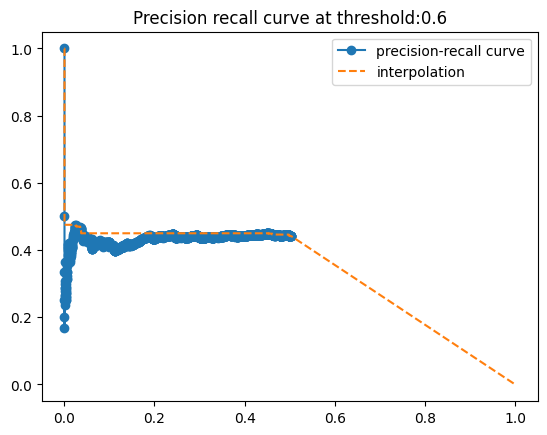

CV (mAP@0.6): 0.22753638066668458


In [16]:
# We test on the above dataset and get the CV score and visualize precision-recall curve
mAP, detail_scores, outputs = mAP_calc.evaluate(thresholds=[0.6], vis=True)
print('CV (mAP@0.6):', mAP)

min area: 0 -> CV (mAP@0.6): 0.2946


min area: 1e4 -> CV (mAP@0.6): 0.3135


min area: 5e4 -> CV (mAP@0.6): 0.3685


min area: 3e5 -> CV (mAP@0.6): 0.4156


min area: 1e6 -> CV (mAP@0.6): 0.5457


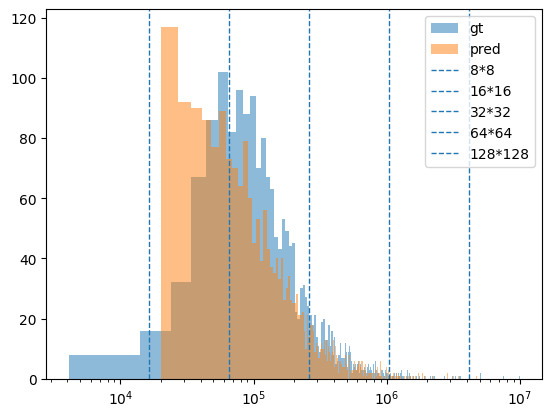

In [17]:
plt.hist(areas_gt, bins=1000, label='gt', alpha=0.5);
plt.hist(areas_pred, bins=1000, label='pred', alpha=0.5);

# set vertical line at 64*64
plt.axvline(255*8*8, linestyle='dashed', linewidth=1, label='8*8')
plt.axvline(255*16*16, linestyle='dashed', linewidth=1, label='16*16')
plt.axvline(255*32*32, linestyle='dashed', linewidth=1, label='32*32')
plt.axvline(255*64*64, linestyle='dashed', linewidth=1, label='64*64')
plt.axvline(255*128*128, linestyle='dashed', linewidth=1, label='128*128')

plt.xscale('log')

plt.legend()

Text(0.5, 0, 'height')

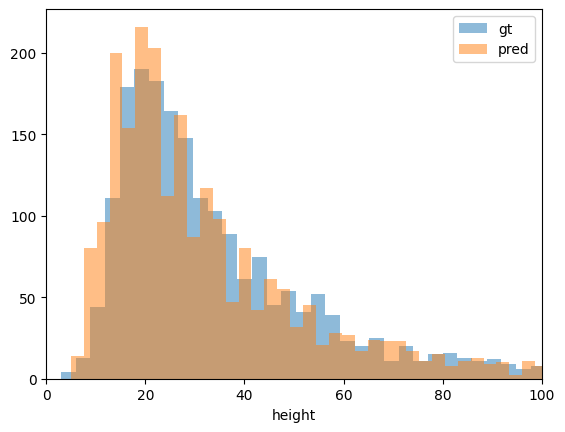

In [18]:
plt.hist(heights_gt, bins=100, label='gt', alpha=0.5);
plt.hist(heights_pred, bins=100, label='pred', alpha=0.5);

plt.xlim(0, 100)
plt.legend()
plt.xlabel('height')

Text(0.5, 0, 'width')

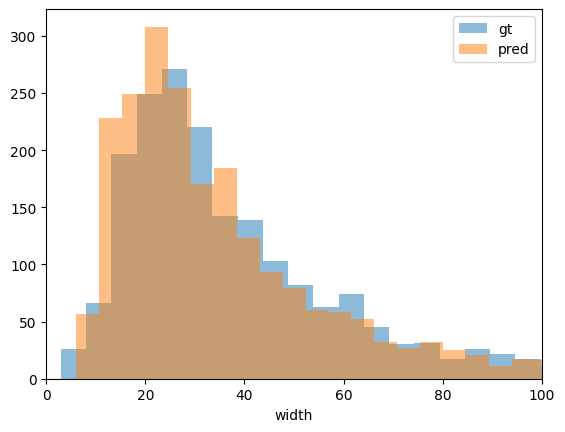

In [19]:
plt.hist(widths_gt, bins=100, label='gt', alpha=0.5);
plt.hist(widths_pred, bins=100, label='pred', alpha=0.5);

plt.xlim(0, 100)
plt.legend()
plt.xlabel('width')

Text(0.5, 0, 'aspect_ratio = width / height')

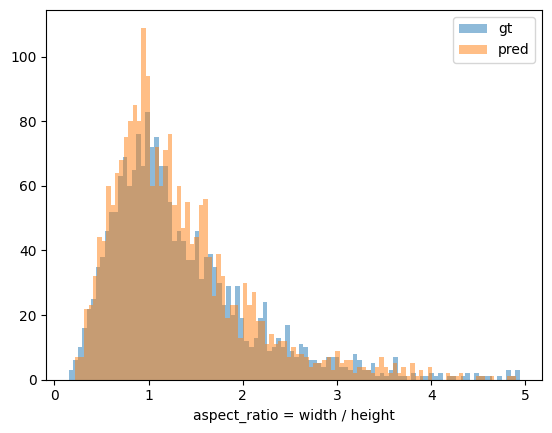

In [20]:
# remove nan from aspect_ratios_gt
aspect_ratios_gt = [a for a in aspect_ratios_gt if not np.isnan(a) and not np.isinf(a) and np.abs(a) < 5]
aspect_ratios_pred  = [a for a in aspect_ratios_pred if not np.isnan(a) and not np.isinf(a) and np.abs(a) < 5]

plt.hist(aspect_ratios_gt, bins=100, label='gt', alpha=0.5);
plt.hist(aspect_ratios_pred, bins=100, label='pred', alpha=0.5);

# plt.xlim(0, 2)
plt.legend()
plt.xlabel('aspect_ratio = width / height')

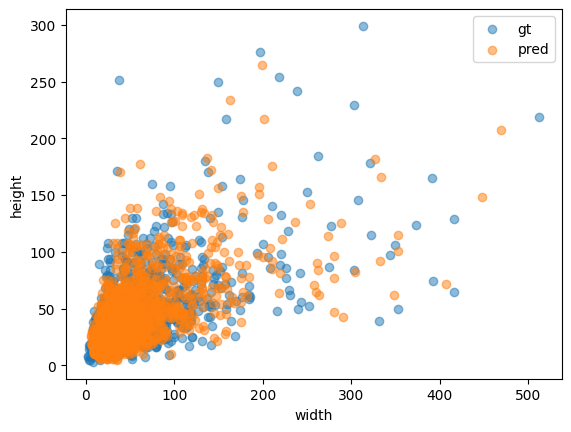

In [21]:
# scatter plot of width and height
plt.scatter(widths_gt, heights_gt, label='gt', alpha=0.5);
plt.scatter(widths_pred, heights_pred, label='pred', alpha=0.5);

plt.xlabel('width')
plt.ylabel('height')

plt.legend()

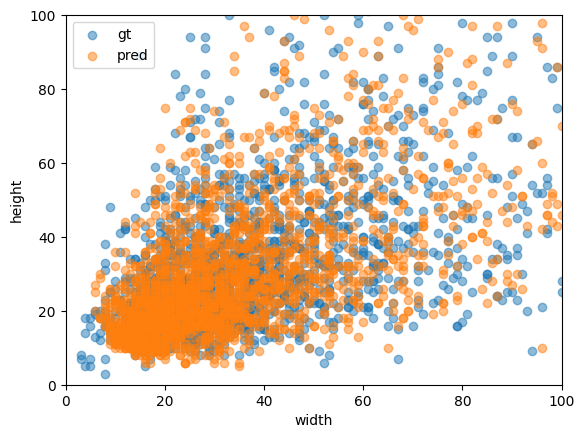

In [22]:
# scatter plot of width and height
plt.scatter(widths_gt, heights_gt, label='gt', alpha=0.5)
plt.scatter(widths_pred, heights_pred, label='pred', alpha=0.5)

# xlim 0 to 100
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.xlabel('width')
plt.ylabel('height')

plt.legend()

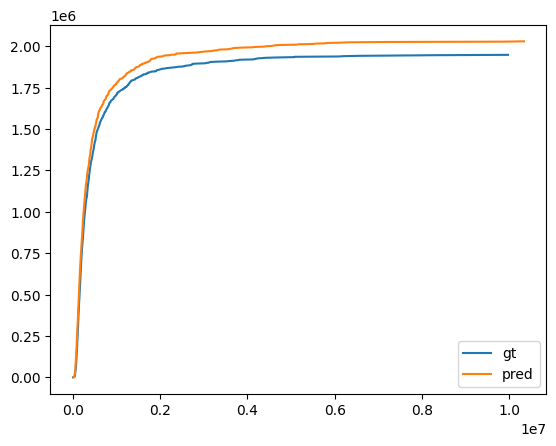

In [ ]:
areas_gt = np.sort(areas_gt)
indices = np.arange(0, len(areas_gt), 1)
indices_cumsum = np.cumsum(indices)
plt.plot(areas_gt, indices_cumsum, label='gt')


areas_pred = np.sort(areas_pred)
indices = np.arange(0, len(areas_pred), 1)
indices_cumsum = np.cumsum(indices)

plt.plot(areas_pred, indices_cumsum, label='pred')

plt.legend()

/tmp/ipykernel_1436893/3341612647.py:5: RuntimeWarning: divide by zero encountered in divide
  indices_cumsum_diff = np.diff(indices_cumsum) / np.diff(areas_gt)
/tmp/ipykernel_1436893/3341612647.py:12: RuntimeWarning: divide by zero encountered in divide
  indices_cumsum_diff = np.diff(indices_cumsum) / np.diff(areas_pred)


(0.0, 2000000.0)

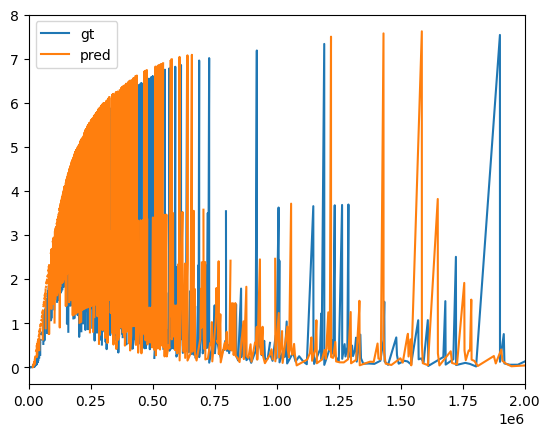

In [ ]:
areas_gt = np.sort(areas_gt)
indices = np.arange(0, len(areas_gt), 1)
indices_cumsum = np.cumsum(indices)
# get derivative of indices_cumsum with respect to areas_gt
indices_cumsum_diff = np.diff(indices_cumsum) / np.diff(areas_gt)
plt.plot(areas_gt[:-1], indices_cumsum_diff, label='gt')


areas_pred = np.sort(areas_pred)
indices = np.arange(0, len(areas_pred), 1)
indices_cumsum = np.cumsum(indices)
indices_cumsum_diff = np.diff(indices_cumsum) / np.diff(areas_pred)
plt.plot(areas_pred[:-1], indices_cumsum_diff, label='pred')

plt.legend()
plt.xlim(0, 0.2e7)